<a href="https://colab.research.google.com/github/dinaglamshowroom/projet-data_oc/blob/main/Projet5_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Introduction & Objectifs

##  Contexte du projet

Le marché mondial de la viande de volaille est en pleine croissance. Pour positionner un nouvel acteur à l’export, il est crucial d’identifier les pays à fort potentiel de consommation.

## Objectif principal de l'étude

L’objectif de cette étude est de segmenter les pays selon des critères nutritionnels, démographiques et économiques afin de recommander les pays les plus propices à l’importation de viande de poulet.

#  Chargement & Préparation des Données

In [1094]:

import pandas as pd
import numpy as np
import seaborn as sns
import os, glob
import pickle
import scipy.stats as st
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy import stats
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from google.colab import files
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import pairwise_distances_argmin_min



cluster_palette = {
    1: "#e41a1c",
    2: "#377eb8",
    3: "#4daf4a",
    4: "#984ea3",
    5: "#ff7f00"
}


##  Importation des datasets

In [964]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [965]:

DATA_DIR = "/content/drive/MyDrive/Projet_5/Data"
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

print("Fichiers CSV trouvés :")
for f in csv_files:
    print(f)

Fichiers CSV trouvés :
/content/drive/MyDrive/Projet_5/Data/Disponibilité_viande_poulet_2021.csv
/content/drive/MyDrive/Projet_5/Data/Population_2011_2021.csv
/content/drive/MyDrive/Projet_5/Data/PIB_2021.csv
/content/drive/MyDrive/Projet_5/Data/Disponibilité alimentiaire_totale_2021.csv
/content/drive/MyDrive/Projet_5/Data/disponibilité_elevage_2021.csv
/content/drive/MyDrive/Projet_5/Data/data_clustering.csv


In [966]:
dfs = {f.split("/")[-1]: pd.read_csv(f) for f in csv_files}

for name, df in dfs.items():
    print(f"{name}: {df.shape}")

Disponibilité_viande_poulet_2021.csv: (740, 15)
Population_2011_2021.csv: (463, 15)
PIB_2021.csv: (381, 15)
Disponibilité alimentiaire_totale_2021.csv: (31144, 15)
disponibilité_elevage_2021.csv: (23660, 15)
data_clustering.csv: (178, 6)


In [967]:
df_poulet = dfs["Disponibilité_viande_poulet_2021.csv"]
df_pib = dfs["PIB_2021.csv"]
df_population = dfs["Population_2011_2021.csv"]
df_dispo_alim = dfs["Disponibilité alimentiaire_totale_2021.csv"]
df_elevage = dfs["disponibilité_elevage_2021.csv"]

##  Nettoyage et harmonisation des noms de pays

des Pays présents dans la population mais absents dans :
* kcal et protéines :

  * Les mêmes pays sont absents dans les deux jeux :

        andorre, anguilla, aruba,ascension, sainte-hélène et tristan da cunha,bermudes, bonaire, saint-eustache et saba,brunéi darussalam, curaçao, gibraltar, groenland

*Remarque* Ce sont souvent des territoires insulaires ou micro-États, rarement inclus dans les statistiques FAO.

* PIB :

Certains grands pays sont aussi exclus, probablement à cause de variations d’écriture :

    * afghanistan, afrique du sud, algérie, allemagne, arabie saoudite, antigua-et-barbuda, angola, etc.

 Solution proposée :

* Nous allons créer un dictionnaire de correspondance pour harmoniser les noms de pays,

* Appliquer ce mapping à tous les fichiers,

* Puis relancer la fusion des datasets.

In [968]:
# Dictionnaire de correspondance pour harmoniser les noms de pays
mapping_pays = {
    "afrique du sud": "afrique du sud",
    "arabie saoudite": "arabie saoudite",
    "antigua-et-barbuda": "antigua-et-barbuda",
    "bonaire, saint-eustache et saba": "bonaire, saint-eustache et saba",
    "ascension, sainte-hélène et tristan da cunha": "sainte-hélène",
    "états-unis d’amérique": "états-unis",
    "république de corée": "corée du sud",
    "république démocratique du congo": "rd congo",
    "république centrafricaine": "centrafrique",
    "république arabe syrienne": "syrie",
    "iran (république islamique d’)": "iran",
    "chine, région administrative spéciale de hong kong": "hong kong",
    "russie": "fédération de russie",
    "vénézuela (république bolivarienne du)": "vénézuela",
    "viet nam": "vietnam",
    "république-unie de tanzanie": "tanzanie",
    "états-unis": "états-unis",
    "r.d. du congo": "rd congo",
    "corée, rep. de": "corée du sud",
}


In [969]:

def harmoniser_pays(df, col="Zone"):
    df[col] = df[col].replace(mapping_pays)
    return df


df_population = harmoniser_pays(df_population)
df_dispo_alim = harmoniser_pays(df_dispo_alim)
df_elevage = harmoniser_pays(df_elevage)
df_poulet = harmoniser_pays(df_poulet)
df_pib = harmoniser_pays(df_pib)


##  Création des variables clés

### Apport Poulet

In [970]:
df_poulet

Code Domaine                                            Domaine  \
0            SCL  Compte Disponibilités et Utilisations (CDU) (2...   
1            SCL  Compte Disponibilités et Utilisations (CDU) (2...   
2            SCL  Compte Disponibilités et Utilisations (CDU) (2...   
3            SCL  Compte Disponibilités et Utilisations (CDU) (2...   
4            SCL  Compte Disponibilités et Utilisations (CDU) (2...   
..           ...                                                ...   
735          SCL  Compte Disponibilités et Utilisations (CDU) (2...   
736          SCL  Compte Disponibilités et Utilisations (CDU) (2...   
737          SCL  Compte Disponibilités et Utilisations (CDU) (2...   
738          SCL  Compte Disponibilités et Utilisations (CDU) (2...   
739          SCL  Compte Disponibilités et Utilisations (CDU) (2...   

     Code zone (M49)            Zone  Code Élément  \
0                  4     Afghanistan          5510   
1                  4     Afghanistan          5610   
2                  4     Afghanistan           664   
3                  4     Afghanistan           674   
4                710  Afrique du Sud          5510   
..               ...             ...           ...   
735              894          Zambie           674   
736              716        Zimbabwe          5510   
737              716        Zimbabwe          5610   
738              716        Zimbabwe           664   
739              716        Zimbabwe           674   

                                               Élément  Code Produit (CPC)  \
0                                           Production               21121   
1                              Importations - quantité               21121   
2       Disponibilité alimentaire (Kcal/personne/jour)               21121   
3    Disponibilité de protéines en quantité (g/pers...               21121   
4                                           Production               21121   
..                                                 ...                 ...   
735  Disponibilité de protéines en quantité (g/pers...               21121   
736                                         Production               21121   
737                            Importations - quantité               21121   
738     Disponibilité alimentaire (Kcal/personne/jour)               21121   
739  Disponibilité de protéines en quantité (g/pers...               21121   

                                   Produit  Code année  Année  \
0    Viande, poulet, fraîche ou réfrigérée        2021   2021   
1    Viande, poulet, fraîche ou réfrigérée        2021   2021   
2    Viande, poulet, fraîche ou réfrigérée        2021   2021   
3    Viande, poulet, fraîche ou réfrigérée        2021   2021   
4    Viande, poulet, fraîche ou réfrigérée        2021   2021   
..                                     ...         ...    ...   
735  Viande, poulet, fraîche ou réfrigérée        2021   2021   
736  Viande, poulet, fraîche ou réfrigérée        2021   2021   
737  Viande, poulet, fraîche ou réfrigérée        2021   2021   
738  Viande, poulet, fraîche ou réfrigérée        2021   2021   
739  Viande, poulet, fraîche ou réfrigérée        2021   2021   

                  Unité      Valeur Symbole  \
0                tonnes    28480.02       I   
1                tonnes    32613.38       X   
2    kcal/personne/jour        5.66       X   
3       g/personne/jour        0.68       X   
4                tonnes  1910000.00       A   
..                  ...         ...     ...   
735     g/personne/jour        1.41       X   
736              tonnes   113000.00       E   
737              tonnes     4071.36       A   
738  kcal/personne/jour       27.63       X   
739     g/personne/jour        3.30       X   

                       Description du Symbole  \
0    Valeur imputée par une agence réceptrice   
1                   Chiffre de source externe   
2                   Chiffre de source externe   
3                   Chi

In [971]:

df_poulet_clean = df_poulet.copy()


df_poulet_clean = df_poulet_clean[
    df_poulet_clean["Élément"].isin([
        "Disponibilité de protéines en quantité (g/personne/jour)",
        "Importations - quantité",
        "Production"
    ])
]


df_poulet_pivot = df_poulet_clean.pivot_table(
    index="Zone",
    columns="Élément",
    values="Valeur"
).reset_index()


df_poulet_pivot.columns.name = None
df_poulet_pivot.rename(columns={
    "Zone": "Pays",
    "Disponibilité de protéines en quantité (g/personne/jour)": "poulet_g_pers_jr",
    "Importations - quantité": "import",
    "Production": "prod"
}, inplace=True)


df_poulet_pivot.head()


Pays  poulet_g_pers_jr     import        prod
0     Afghanistan              0.68   32613.38    28480.02
1  Afrique du Sud             17.85  345579.16  1910000.00
2         Albanie              5.56   21929.50    13250.00
3         Algérie              2.78       0.40   273520.20
4       Allemagne              4.92  475448.52  1080000.00

In [972]:
df_poulet_pivot["import_ratio"] = (df_poulet_pivot["import"] /(( df_poulet_pivot["import"]) + df_poulet_pivot["prod"]))

In [973]:
df_poulet_pivot.head()

Pays  poulet_g_pers_jr     import        prod  import_ratio
0     Afghanistan              0.68   32613.38    28480.02      0.533828
1  Afrique du Sud             17.85  345579.16  1910000.00      0.153211
2         Albanie              5.56   21929.50    13250.00      0.623360
3         Algérie              2.78       0.40   273520.20      0.000001
4       Allemagne              4.92  475448.52  1080000.00      0.305667

In [974]:
poulet = df_poulet_pivot[['Pays', 'poulet_g_pers_jr']]
poulet.head()


Pays  poulet_g_pers_jr
0     Afghanistan              0.68
1  Afrique du Sud             17.85
2         Albanie              5.56
3         Algérie              2.78
4       Allemagne              4.92

In [975]:
poulet2 = df_poulet_pivot[['Pays', 'import',	'prod',	'import_ratio']]
poulet2.head()

Pays     import        prod  import_ratio
0     Afghanistan   32613.38    28480.02      0.533828
1  Afrique du Sud  345579.16  1910000.00      0.153211
2         Albanie   21929.50    13250.00      0.623360
3         Algérie       0.40   273520.20      0.000001
4       Allemagne  475448.52  1080000.00      0.305667

In [976]:
poulet2.describe()

import          prod  import_ratio
count  1.820000e+02  1.840000e+02    179.000000
mean   7.595635e+04  6.470770e+05      0.368674
std    1.743867e+05  2.150553e+06      0.359939
min    4.000000e-01  0.000000e+00      0.000001
25%    3.306245e+03  9.268800e+03      0.045684
50%    1.562580e+04  6.797013e+04      0.219162
75%    6.382837e+04  3.105722e+05      0.755617
max    1.462453e+06  1.900350e+07      1.000000

### Variation de population (pop_evo_ratio)

In [977]:
# 1. Population : évolution entre 2011 et 2021
pop_2011 = df_population[(df_population["Année"] == 2011) &
                         (df_population["Élément"] == "Population totale")][["Zone", "Valeur"]].rename(columns={"Valeur": "pop_2011"})

pop_2021 = df_population[(df_population["Année"] == 2021) &
                         (df_population["Élément"] == "Population totale")][["Zone", "Valeur"]].rename(columns={"Valeur": "pop_2021"})

df_pop = pd.merge(pop_2011, pop_2021, on="Zone")
df_pop["pop_evo_ratio"] = 100 * (df_pop["pop_2021"] - df_pop["pop_2011"]) / df_pop["pop_2011"]


In [978]:
df_pop.describe()



pop_2011      pop_2021  pop_evo_ratio
count  2.300000e+02  2.300000e+02     230.000000
mean   3.042960e+04  3.403271e+04      13.187954
std    1.269163e+05  1.378174e+05      14.835194
min    1.599000e+00  1.813000e+00     -20.305546
25%    3.957710e+02  4.122935e+02       2.119079
50%    4.781400e+03  5.425425e+03      11.837031
75%    1.730793e+04  2.190364e+04      24.209611
max    1.360251e+06  1.426437e+06      55.442282

In [979]:
df_pop.rename(columns={"Zone": "Pays"}, inplace=True)

### Apport calorique total

In [980]:
kcal = df_dispo_alim[
    df_dispo_alim["Élément"].str.contains("Kcal", case=False)
]

kcal = kcal.groupby("Zone")["Valeur"].sum().reset_index()
kcal.columns = ["Pays", "kcal_total_pers_jr"]


In [981]:

kcal.describe()

kcal_total_pers_jr
count          187.000000
mean          2930.964171
std            463.937935
min           1771.730000
25%           2614.650000
50%           2952.600000
75%           3295.855000
max           3898.190000

In [982]:
kcal.head()

Pays  kcal_total_pers_jr
0     Afghanistan             2239.62
1  Afrique du Sud             2772.36
2         Albanie             3330.25
3         Algérie             3499.10
4       Allemagne             3620.22

In [983]:
kcal.describe()

kcal_total_pers_jr
count          187.000000
mean          2930.964171
std            463.937935
min           1771.730000
25%           2614.650000
50%           2952.600000
75%           3295.855000
max           3898.190000

 ### Part des protéines animales

In [984]:
prot_anim = df_elevage[
    df_elevage["Élément"].str.contains("protéines", case=False)
]

prot_anim = prot_anim.groupby("Zone")["Valeur"].sum().reset_index()
prot_anim.columns = ["Pays", "proteines_animales"]


In [985]:
prot_anim.head()

Pays  proteines_animales
0     Afghanistan               10.27
1  Afrique du Sud               39.20
2         Albanie               57.03
3         Algérie               24.80
4       Allemagne               69.31

In [986]:
prot_anim.describe()

proteines_animales
count          189.000000
mean            38.128201
std             21.906004
min              2.100000
25%             17.780000
50%             37.270000
75%             55.150000
max             92.500000

### Apport protéique total

In [987]:
prot_tot = df_dispo_alim[
    df_dispo_alim["Élément"].str.contains("protéines", case=False)
]

prot_tot = prot_tot.groupby("Zone")["Valeur"].sum().reset_index()
prot_tot.columns = ["Pays", "proteines_total_g_pers_jr"]

In [988]:
prot_tot.head()

Pays  proteines_total_g_pers_jr
0     Afghanistan                      61.16
1  Afrique du Sud                      82.27
2         Albanie                     115.71
3         Algérie                      95.33
4       Allemagne                     110.54

In [989]:
prot_tot.rename(columns={"Zone": "Pays"}, inplace=True)

### PIB par habitant - stabilité politique



In [990]:
df_pivot_PIB = df_pib.pivot_table(
    values='Valeur',
    index=['Zone'],
      columns='Produit',
    aggfunc='sum'
).reset_index()

In [991]:
pib_stab = df_pivot_PIB.rename(columns={
    'Zone': 'Pays',
    'PIB par habitant, ($ PPA internationaux constants de 2021)' : 'PIB_habitant',
 'Stabilité politique et absence de violence/terrorisme (indice)' : 'stab'
}).rename_axis(None, axis=1)

In [992]:
pib_stab

Pays  PIB_habitant  stab
0              Afghanistan        2144.2 -2.52
1           Afrique du Sud       13711.3 -0.75
2                  Albanie       16126.8  0.20
3                  Algérie       14496.9 -0.99
4                Allemagne       62530.8  0.73
..                     ...           ...   ...
190               Érythrée           NaN -1.06
191  États-Unis d'Amérique       71307.4 -0.01
192               Éthiopie        2588.4 -2.18
193          Îles Marshall        6705.9  0.93
194           Îles Salomon        2518.4  0.54

[195 rows x 3 columns]

## Jointure Finale

In [993]:
df_pop

Pays   pop_2011   pop_2021  \
0                               Afghanistan  29347.708  40000.412   
1                            Afrique du Sud  52995.205  61502.603   
2                                   Albanie   2911.504   2849.635   
3                                   Algérie  36903.376  44761.099   
4                                 Allemagne  80857.873  83697.083   
..                                      ...        ...        ...   
225  Venezuela (République bolivarienne du)  29185.212  28237.826   
226                                Viet Nam  88468.314  98935.098   
227                                   Yémen  27582.897  37140.230   
228                                  Zambie  14437.796  19603.607   
229                                Zimbabwe  13595.424  15797.210   

     pop_evo_ratio  
0        36.298249  
1        16.053147  
2        -2.124984  
3        21.292694  
4         3.511359  
..             ...  
225      -3.246117  
226      11.831111  
227      34.649490  
228      35.779776  
229      16.195052  

[230 rows x 4 columns]

In [994]:

df_min = prot_tot.merge(kcal, on="Pays", how="inner")
df_min = df_min.merge(df_pop[["Pays", "pop_evo_ratio","pop_2021"]], on="Pays", how="inner")
df_min = df_min.merge(poulet, on="Pays", how="left")


création d'un ratio poulet/proteines totales

In [995]:

df_min['ratio_g_poulet_prot'] = df_min['poulet_g_pers_jr'] / df_min['proteines_total_g_pers_jr']

df_min


Pays  proteines_total_g_pers_jr  kcal_total_pers_jr  \
0              Afghanistan                      61.16             2239.62   
1           Afrique du Sud                      82.27             2772.36   
2                  Albanie                     115.71             3330.25   
3                  Algérie                      95.33             3499.10   
4                Allemagne                     110.54             3620.22   
..                     ...                        ...                 ...   
180               Équateur                      69.00             2561.75   
181  États-Unis d'Amérique                     122.10             3892.91   
182               Éthiopie                      76.83             2463.44   
183          Îles Marshall                     114.74             3208.40   
184           Îles Salomon                      58.96             2311.29   

     pop_evo_ratio    pop_2021  poulet_g_pers_jr  ratio_g_poulet_prot  
0        36.298249   40000.412              0.68             0.011118  
1        16.053147   61502.603             17.85             0.216969  
2        -2.124984    2849.635              5.56             0.048051  
3        21.292694   44761.099              2.78             0.029162  
4         3.511359   83697.083              4.92             0.044509  
..             ...         ...               ...                  ...  
180      15.373823   17682.454             12.41             0.179855  
181       8.295429  340161.441             20.66             0.169206  
182      31.120373  122138.588              0.18             0.002343  
183     -20.305546      41.367             29.38             0.256057  
184      37.914440     762.591              3.21             0.054444  

[185 rows x 7 columns]

# Analyse exploratoire

### Analyse Univariée

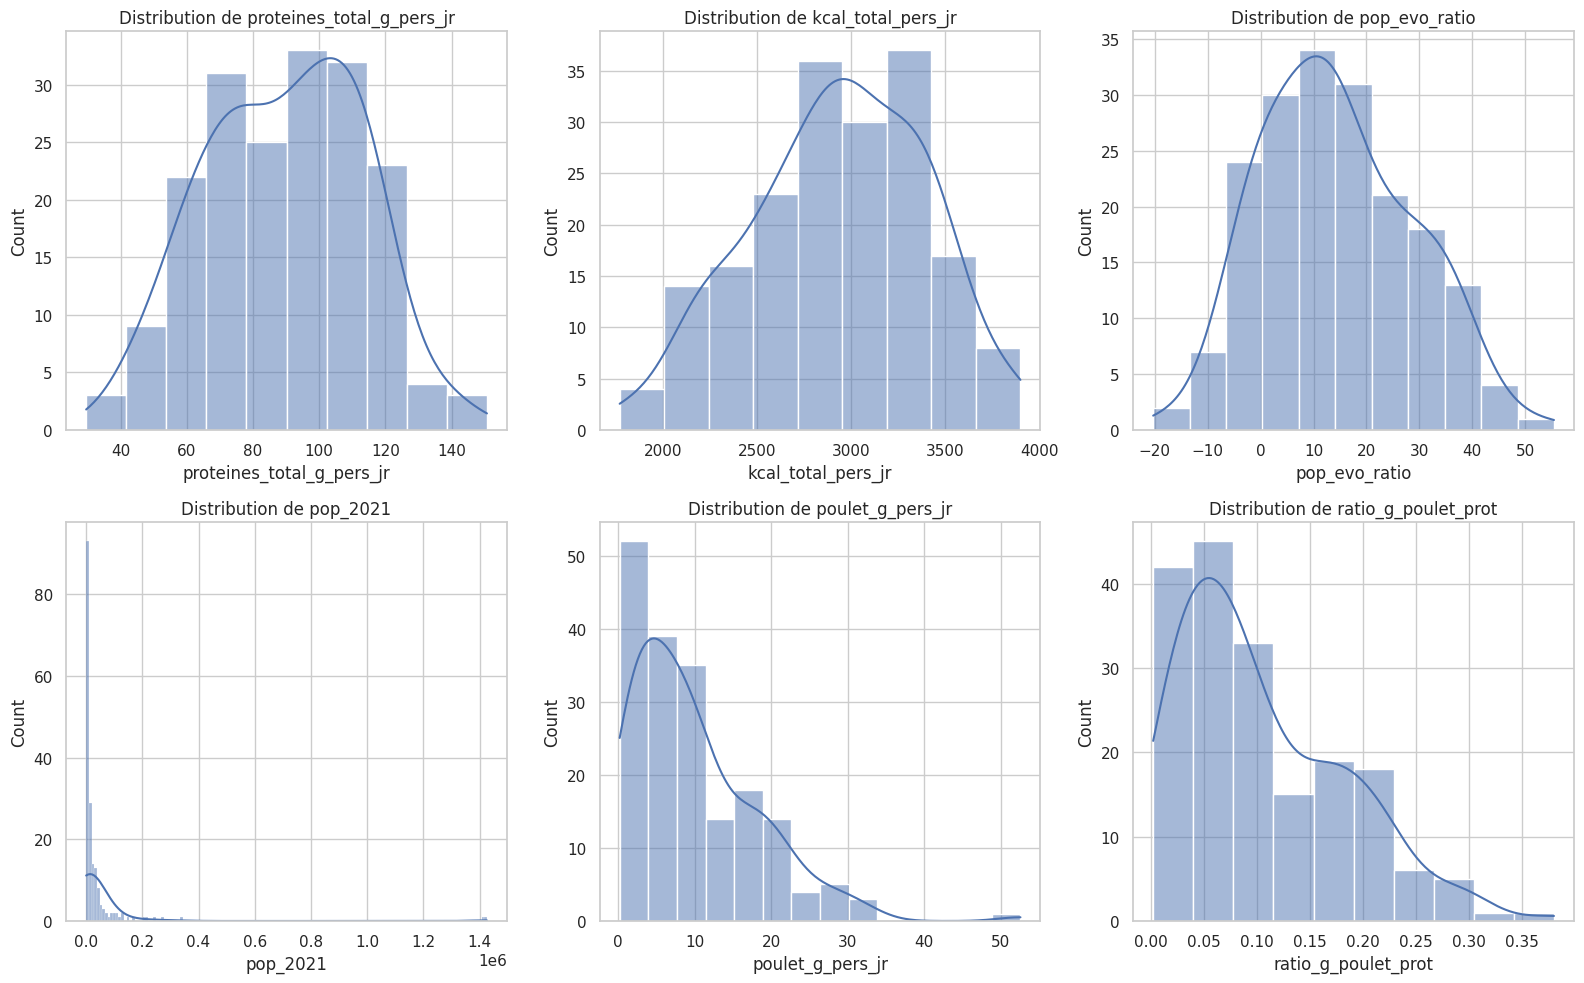

In [996]:
plt.figure(figsize=(16, 10))
for i, col in enumerate(df_min.columns[1:], 1):
    plt.subplot(2, 3, i)
    sns.histplot(df_min[col], kde=True)
    plt.title(f"Distribution de {col}")

plt.tight_layout()
plt.show()



* **proteines_total_g_pers_jr**

La distribution est **relativement symétrique** et proche d’une loi normale, ce qui est interessant pour certaines analyses statistiques.  
Cela suggère une bonne répartition des apports protéiques moyens dans les différents pays.



* **kcal_total_pers_jr**

Comme les protéines, la courbe est **centrée et régulière**, bien que légèrement asymétrique à droite.  
Cela reflète des différences de consommation énergétique globalement homogènes, avec quelques pays à forte consommation.



* **pop_evo_ratio**

La distribution est **asymétrique à droite** (longue traîne), ce qui signifie que certains pays ont connu une forte croissance démographique entre 2003 et 2013.  
Quelques valeurs négatives ou proches de 0 sont présentes, ce qui est cohérent pour des pays en stagnation ou déclin.


* **poulet_g_pers_jr**

Distribution clairement **asymétrique positive** : la majorité des pays consomment peu de poulet, mais une minorité a une consommation beaucoup plus élevée.
Cela indique un fort contraste entre pays consommateurs et non consommateurs.


* **ratio_g_poulet_prot**

Même observation : la distribution est très **concentrée vers la gauche**, ce qui montre que dans beaucoup de pays, **le poulet ne
représente qu’une faible part de l’apport en protéines**.
Quelques pays ont cependant une forte dépendance à cette source.



Les distributions montrent :
- une bonne variété dans les profils des pays,
- des variables relativement exploitables sans transformations lourdes,
- une nécessité possible de **standardisation** pour compenser les échelles très différentes (notamment pour -poulet_g_pers_jr-

Cette analyse valide l’intérêt de méthodes comme **l’ACP** et le **clustering**, qui permettront de regrouper les pays aux profils similaires.


### Analyse Bivariée

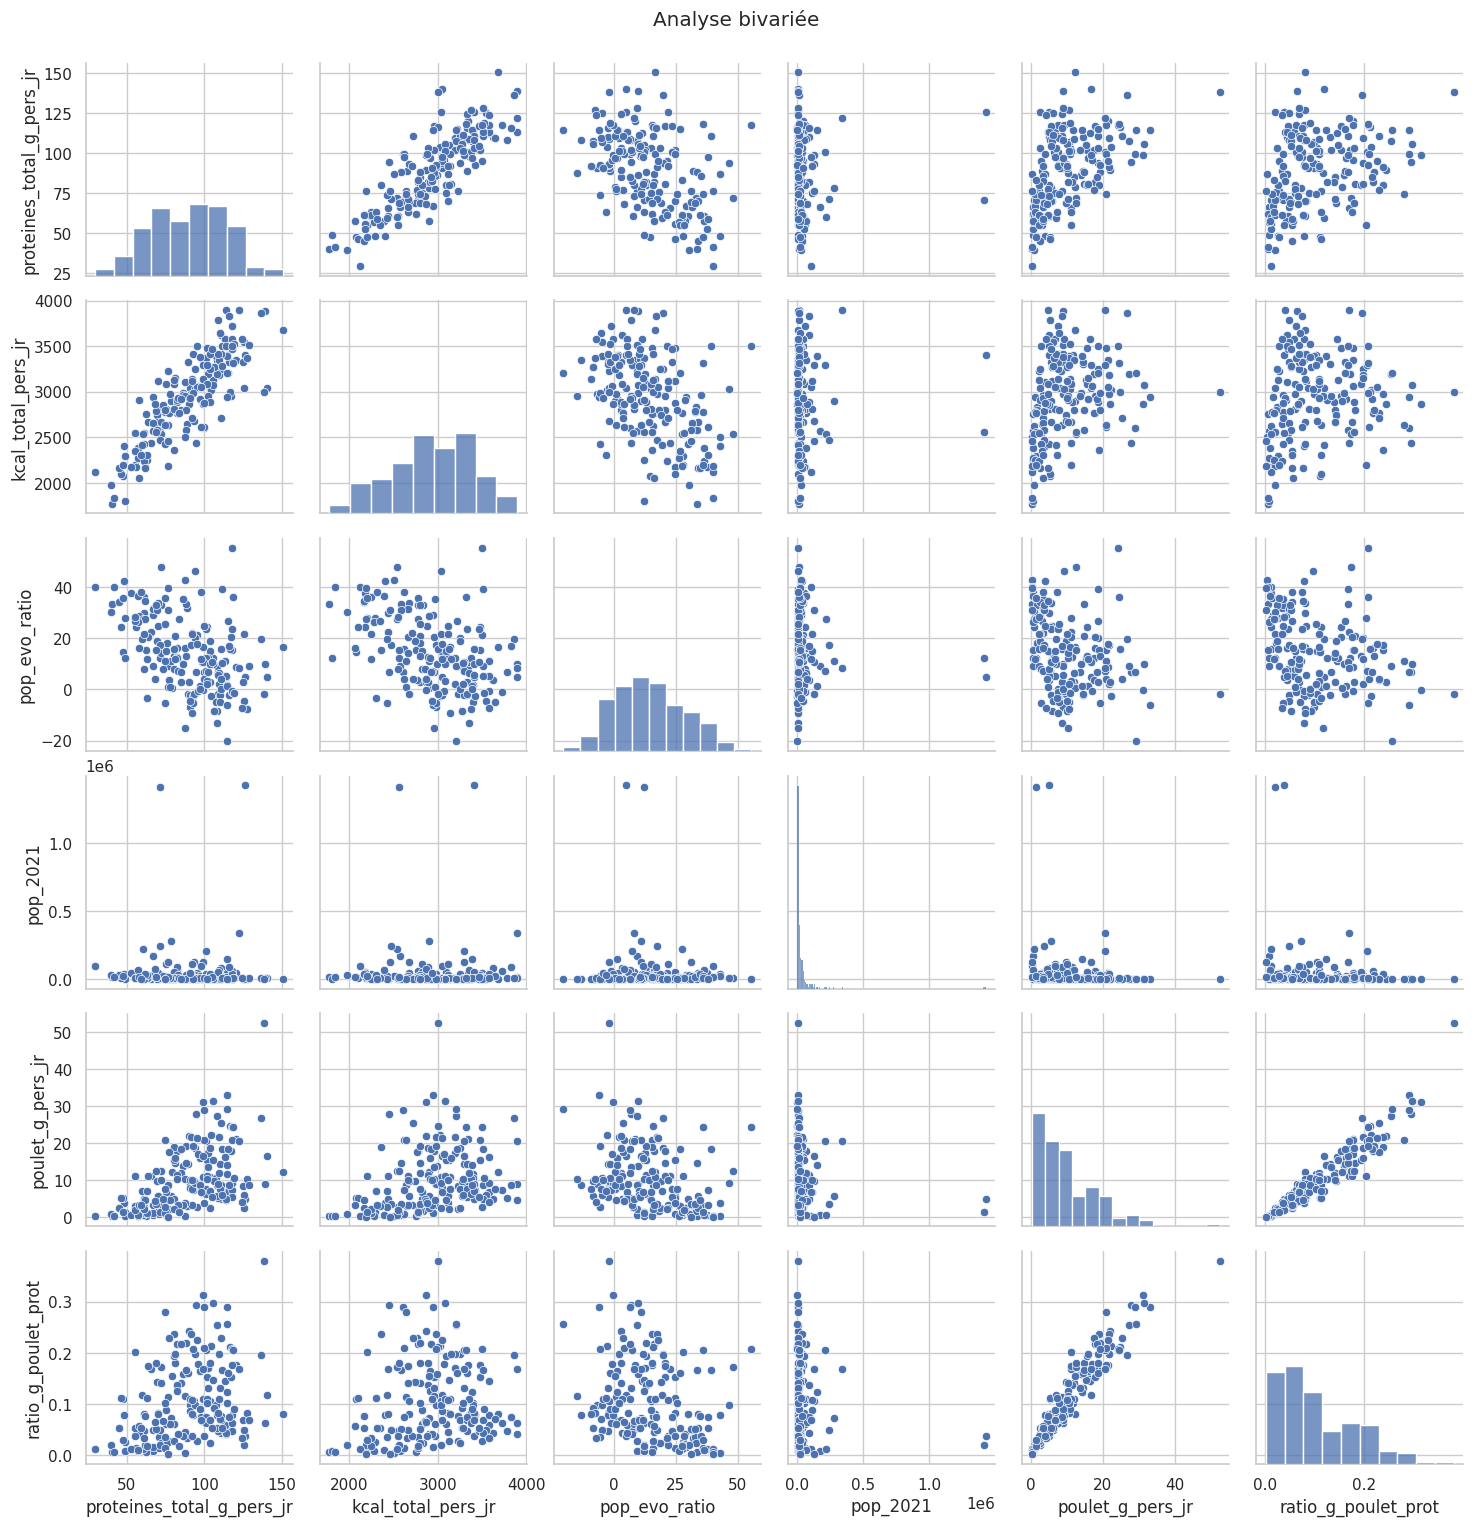

In [997]:
sns.pairplot(df_min.drop(columns=["Pays"]))
plt.suptitle("Analyse bivariée", y=1.02)
plt.show()


-
* Corrélations fortes observées :

  * **proteines_total_g_pers_jr - kcal_total_pers_jr**

    Forte corrélation positive : plus un pays consomme de protéines, plus il consomme de calories. C’est logique car les protéines sont une composante énergétique.

  * **poulet_g_pers_jr - ratio_kcal_poulet_prot**

    Corrélation très forte (quasi linéaire) : cela confirme que le ratio est dérivé directement de la quantité de poulet consommée.

------------------------------

* Relations faibles ou nulles :

  * **pop_evo_ratio n’est corrélée à aucune autre variable**.  
    Cela indique que l’évolution de la population n’est pas directement liée aux apports alimentaires.

   * **ratio_g_poulet_prot n’a pas de relation claire avec les protéines ou calories totales**  
    Cela signifie que la dépendance au poulet peut varier indépendamment du niveau nutritionnel global.

* Autres observations :

   * Pas de relation non-linéaire ou structure anormale (ex : effet en U, etc.)
    * Pas de valeurs aberrantes évidentes, mais quelques dispersions importantes.

---


Conclusion :
Ce pairplot met en évidence deux points clés :

* Certaines variables sont redondantes **kcal_total et proteines_total**, ce qui **justifie l’usage de l’ACP** pour réduire la dimensionnalité.

* Les variables se complètent bien (démographie, nutrition, dépendance au poulet), donc elles sont toutes **pertinentes à conserver pour la suite**.

Cette étape valide l’intérêt d’un travail de **clustering multivarié**, basé sur l’ensemble de ces indicateurs.


##  Matrice de corrélation

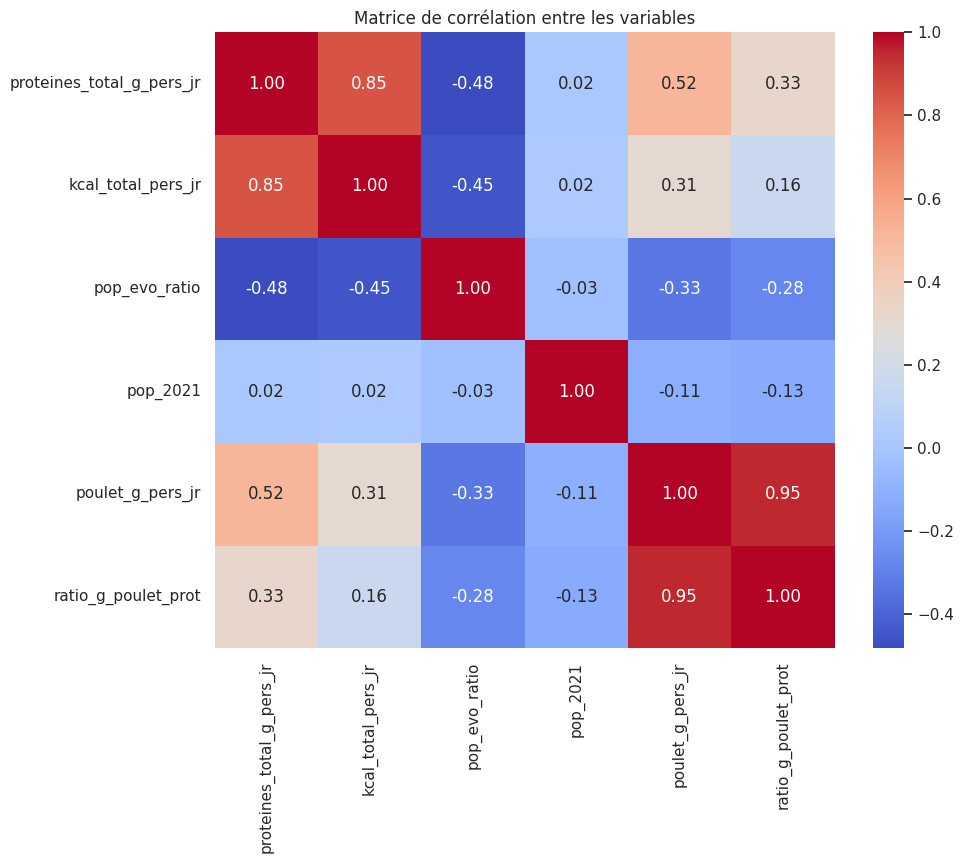

In [998]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_min.drop(columns=["Pays"]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation entre les variables")
plt.show()



-La matrice ci-dessus présente les coefficients de corrélation de Pearson entre les variables quantitatives retenues pour l’étude.

* **Corrélations fortes (ρ > 0.8)**

    * **protéines_total_g_pers_jr – kcal_total_pers_jr : ρ = 0.85**

-> Corrélation attendue : les protéines contribuent fortement à l'apport calorique total.
=> Implication : ces deux variables étant partiellement redondantes, leur présence simultanée dans une ACP pourrait surreprésenter l’effet nutritionnel global.

  * **poulet_g_pers_jr- ratio_g_poulet_prot  :ρ= 0.95**

->  Corrélation quasi-parfaite, car le ratio est mathématiquement dérivé de la quantité de poulet.
=>  Implication : ces deux variables sont multicolinéaires → on en gardera une seule dans les analyses ultérieures.

* **Corrélations modérées à faibles**

    * **poulet_g_pers_jr – proteines_total_g_pers_jr : ρ = 0.52**
->  Relation logique : les pays qui consomment plus de poulet tendent à avoir un régime plus riche en protéines, sans pour autant que la dépendance soit exclusive.

* **Corrélations négatives (modérées)**

  * **pop_evo_ratio – proteines_total : ρ = -0.48**

  * pop_evo_ratio – kcal_total : ρ = -0.45
 -> Les pays à forte croissance démographique sont souvent ceux avec une consommation alimentaire plus faible par habitant. Cela reflète les différences Nord/Sud global et des écarts structurels de développement.

**CCL**

La matrice confirme les relations mises en évidence dans le pairplot

Elle justifie pleinement :

* La réduction de dimension via ACP

* La standardisation des variables

* L'exclusion de variables redondantes (notamment le ratio du poulet)

Elle renforce l’intérêt d’un clustering multivarié, en soulignant la complémentarité entre nutrition, démographie et dépendance au poulet.

#  Classification hiérarchique (CAH)

On commence par fixer "Pays" comme index puis on selectionne uniquement nos 4 variables

In [999]:

df_dendo = df_min.set_index('Pays')

df_dendo = df_dendo[["poulet_g_pers_jr", "proteines_total_g_pers_jr", "pop_evo_ratio", "kcal_total_pers_jr"]]

df_dendo.head(2)


poulet_g_pers_jr  proteines_total_g_pers_jr  pop_evo_ratio  \
Pays                                                                         
Afghanistan                 0.68                      61.16      36.298249   
Afrique du Sud             17.85                      82.27      16.053147   

                kcal_total_pers_jr  
Pays                                
Afghanistan                2239.62  
Afrique du Sud             2772.36

##  Génération du dendrogramme (Ward)

Un dendrogramme est un diagramme en forme d'arbre qui représente visuellement la disposition des clusters produits par un regroupement hiérarchique

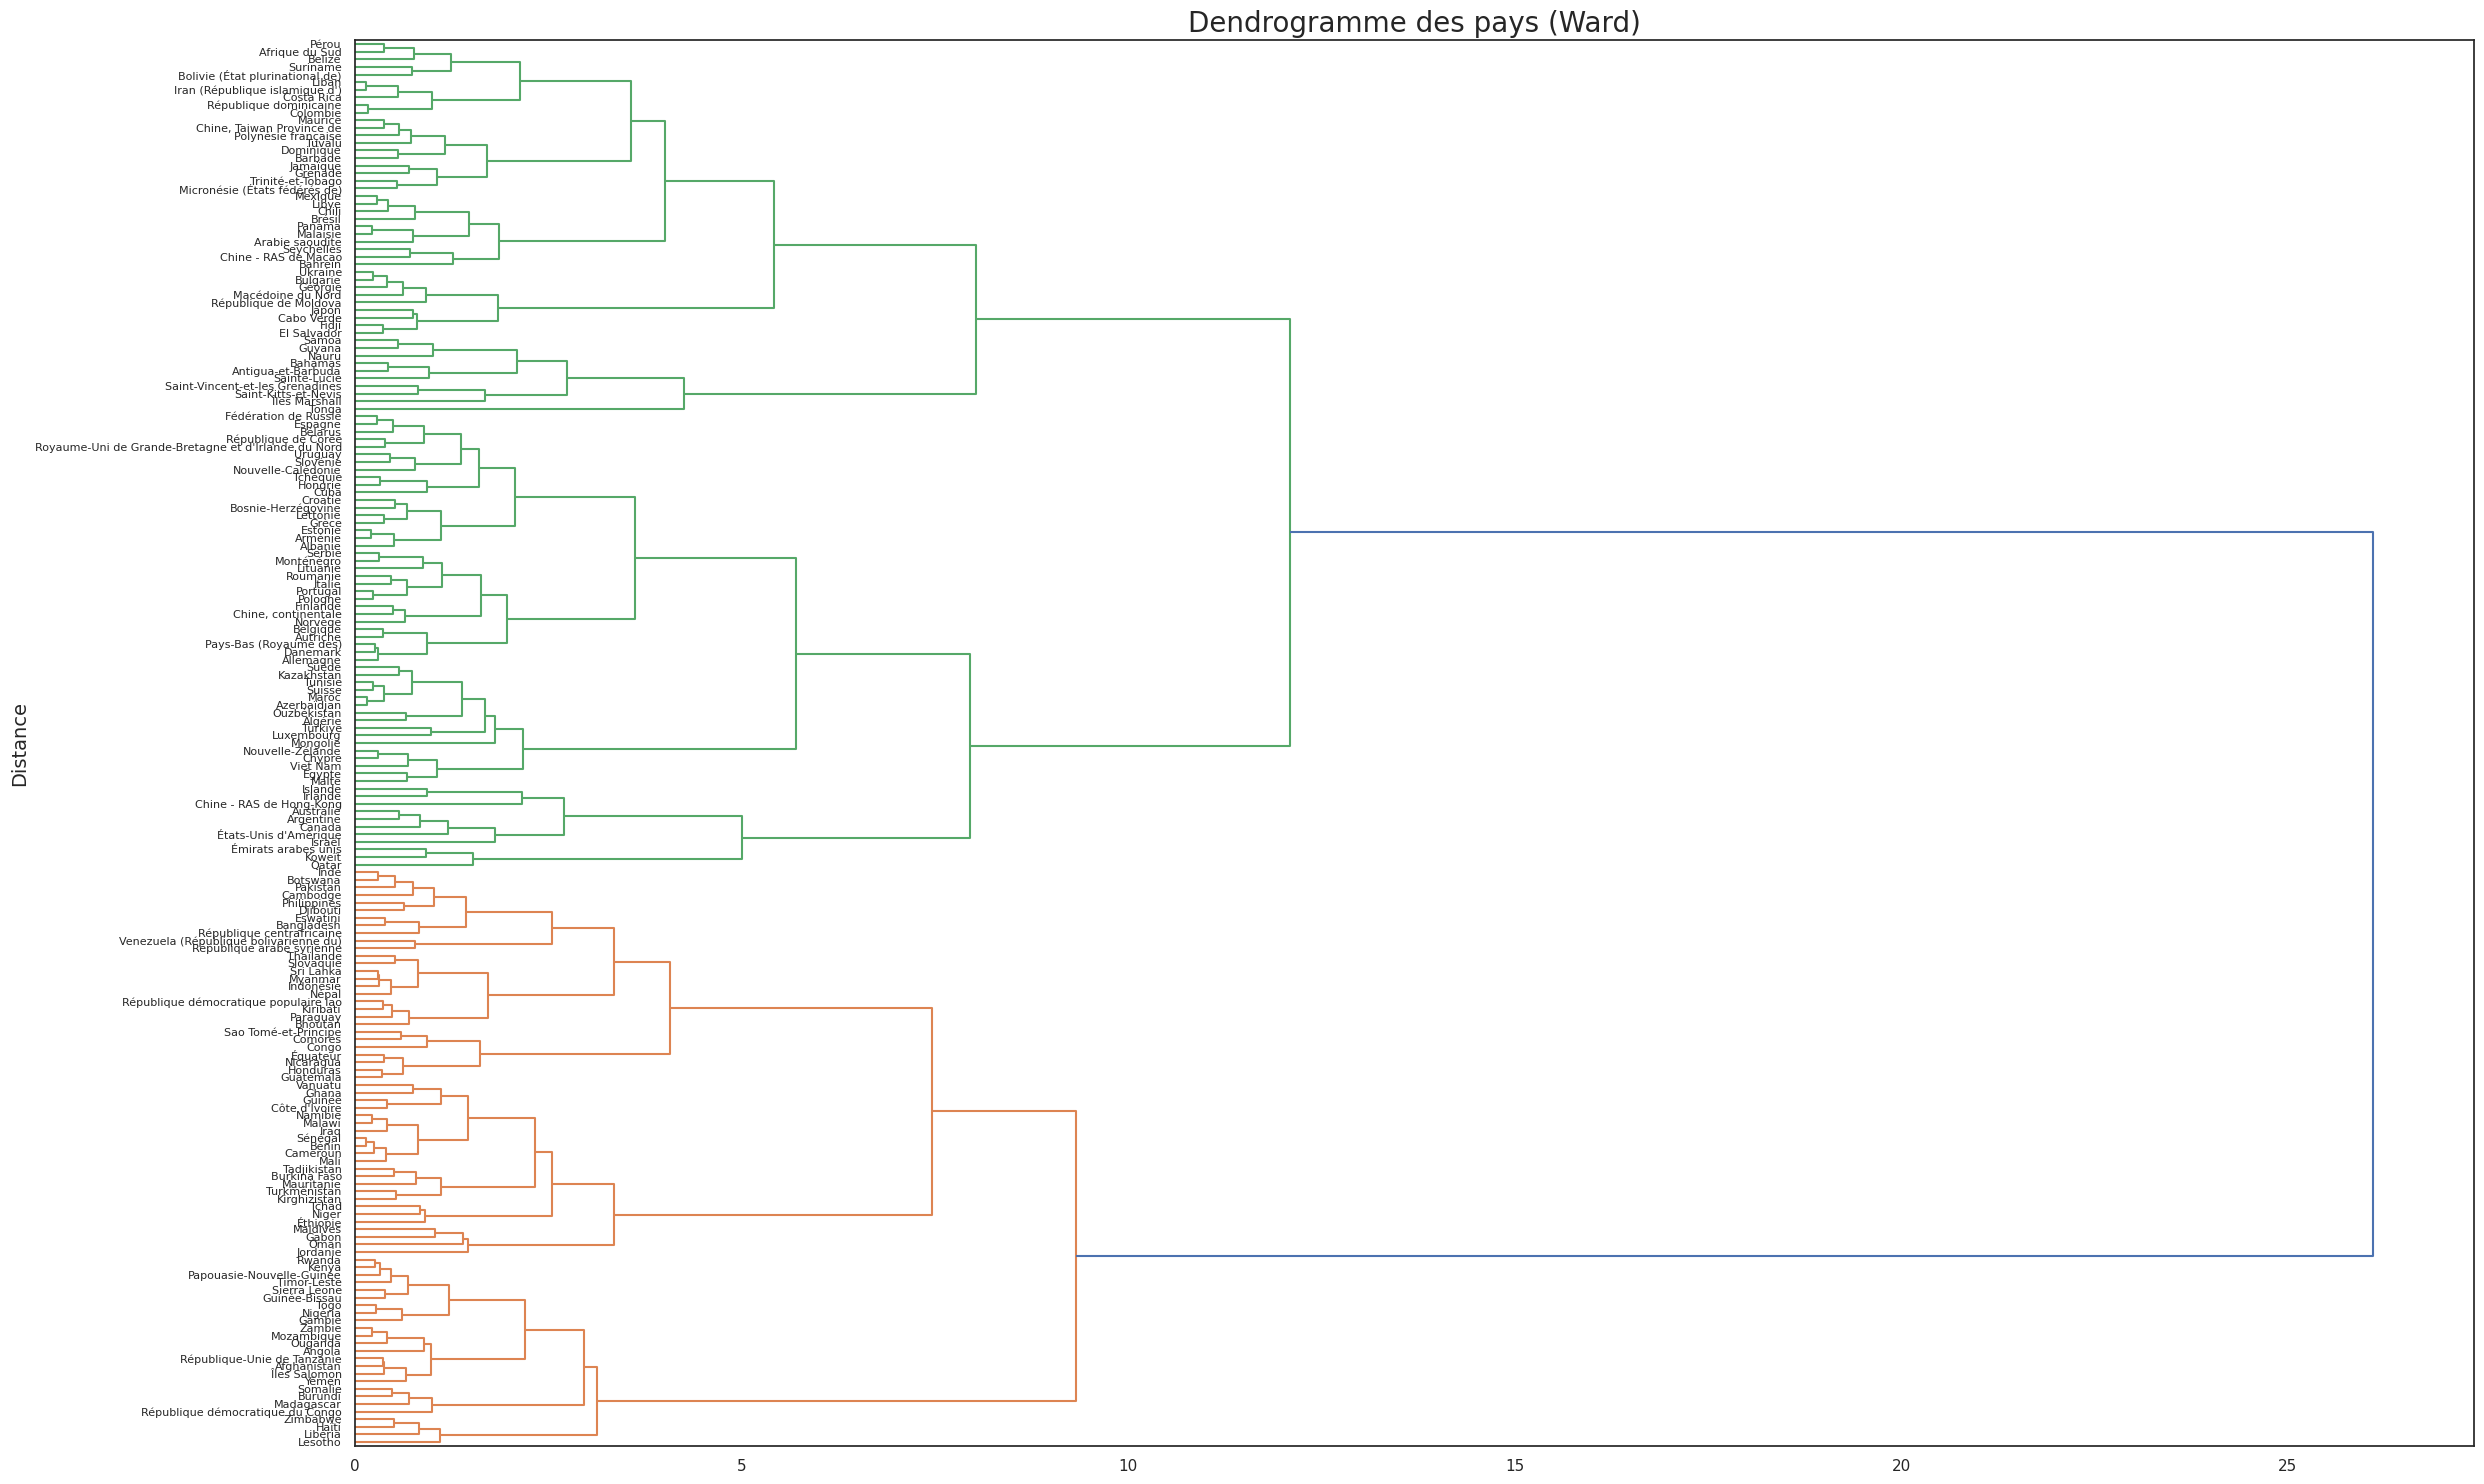

In [1000]:

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_dendo)

# Matrice de linkage avec Ward
Z = linkage(df_scaled, method='ward', metric='euclidean')

# Tracé du dendrogramme
plt.figure(figsize=(25, 15))
sns.set_style('white')
plt.title('Dendrogramme des pays (Ward)', fontsize=20)
plt.ylabel('Distance', fontsize=14)
dendrogram(Z, labels=df_dendo.index, leaf_font_size=8, orientation='right')
plt.tight_layout()
plt.savefig("dendrogramme.png", dpi=300)
plt.show()



- On observe un **saut net de distance** entre les dernières fusions : cela suggère que **4 à 5 clusters** est un choix raisonnable.

- Ce type de saut indique un **changement brutal dans la dissimilarité entre groupes**, ce qui justifie un découpage à ce niveau.


Notre a prioris notre choix se porterait sur 5 clusters, nous allons le confirmer avec la courbe du coude

### Graphique de la variance expliquée cumulée

Ce graphique représente la part d'inertie expliquée cumulée en fonction du nombre de groupes créés par la méthode hiérarchique.

Il est utilisé pour choisir un nombre optimal de groupes à extraire du dendrogramme, dans le cadre d'une classification ascendante hiérarchique (CAH).

L'objectif est de trouver le nombre de clusters qui permet d'expliquer une part suffisante de la variance (ou inertie) des données tout en évitant de sursegmenter.

In [1001]:
X = df_dendo.values
X.shape

(185, 4)

In [1002]:
scale = preprocessing.StandardScaler().fit(X)
X_scaled = scale.transform(X)

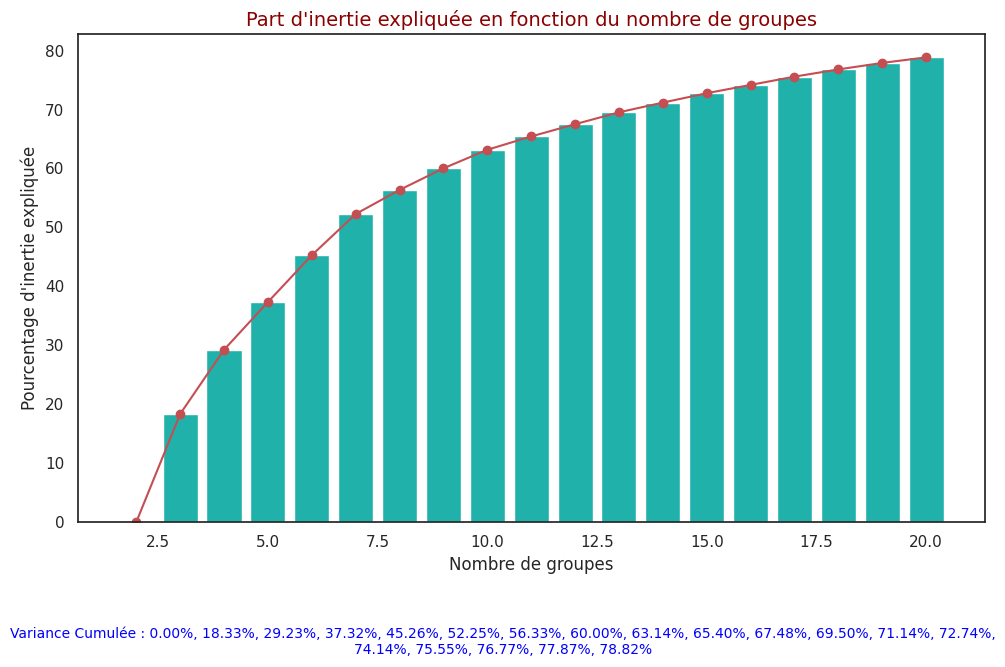

In [1003]:

Z = linkage(X_scaled, method='ward')


K = range(2, 21)
inertie = []

for k in K:
    labels = fcluster(Z, t=k, criterion='maxclust')


    groupes = [X_scaled[labels == i] for i in range(1, k+1)]
    inertie_k = 0
    for group in groupes:
        if len(group) > 0:
            center = group.mean(axis=0)
            dists = ((group - center) ** 2).sum()
            inertie_k += dists
    inertie.append(inertie_k)


inertie_totale = inertie[0]
inertie_expliquee = [100 * (1 - i / inertie[0]) for i in inertie]


plt.figure(figsize=(10, 6))
plt.bar(K, inertie_expliquee, color='lightseagreen')
plt.plot(K, inertie_expliquee, 'o-r')
plt.title("Part d'inertie expliquée en fonction du nombre de groupes", fontsize=14, color='darkred')
plt.xlabel("Nombre de groupes")
plt.ylabel("Pourcentage d'inertie expliquée")


text = "Variance Cumulée : " + ", ".join([f"{v:.2f}%" for v in inertie_expliquee])
plt.figtext(0.5, -0.1, text, wrap=True, horizontalalignment='center', fontsize=10, color='blue')
plt.tight_layout()
plt.show()


- Jusqu'à **5 groupes**, l'inertie expliquée **augmente rapidement** : 52,25% à ce stade.

- À partir de **6 à 8 clusters**, le gain devient plus modéré (ex : 60% pour 10 clusters).

- Après **10 groupes**, la courbe commence à **s’aplatir nettement** → les gains deviennent très faibles.

- Le **"coude" visuel** se situe autour de **5 groupes**. Cela recoupe analyse du dendogramme précédent

###  Coupe du dendogramme à 5

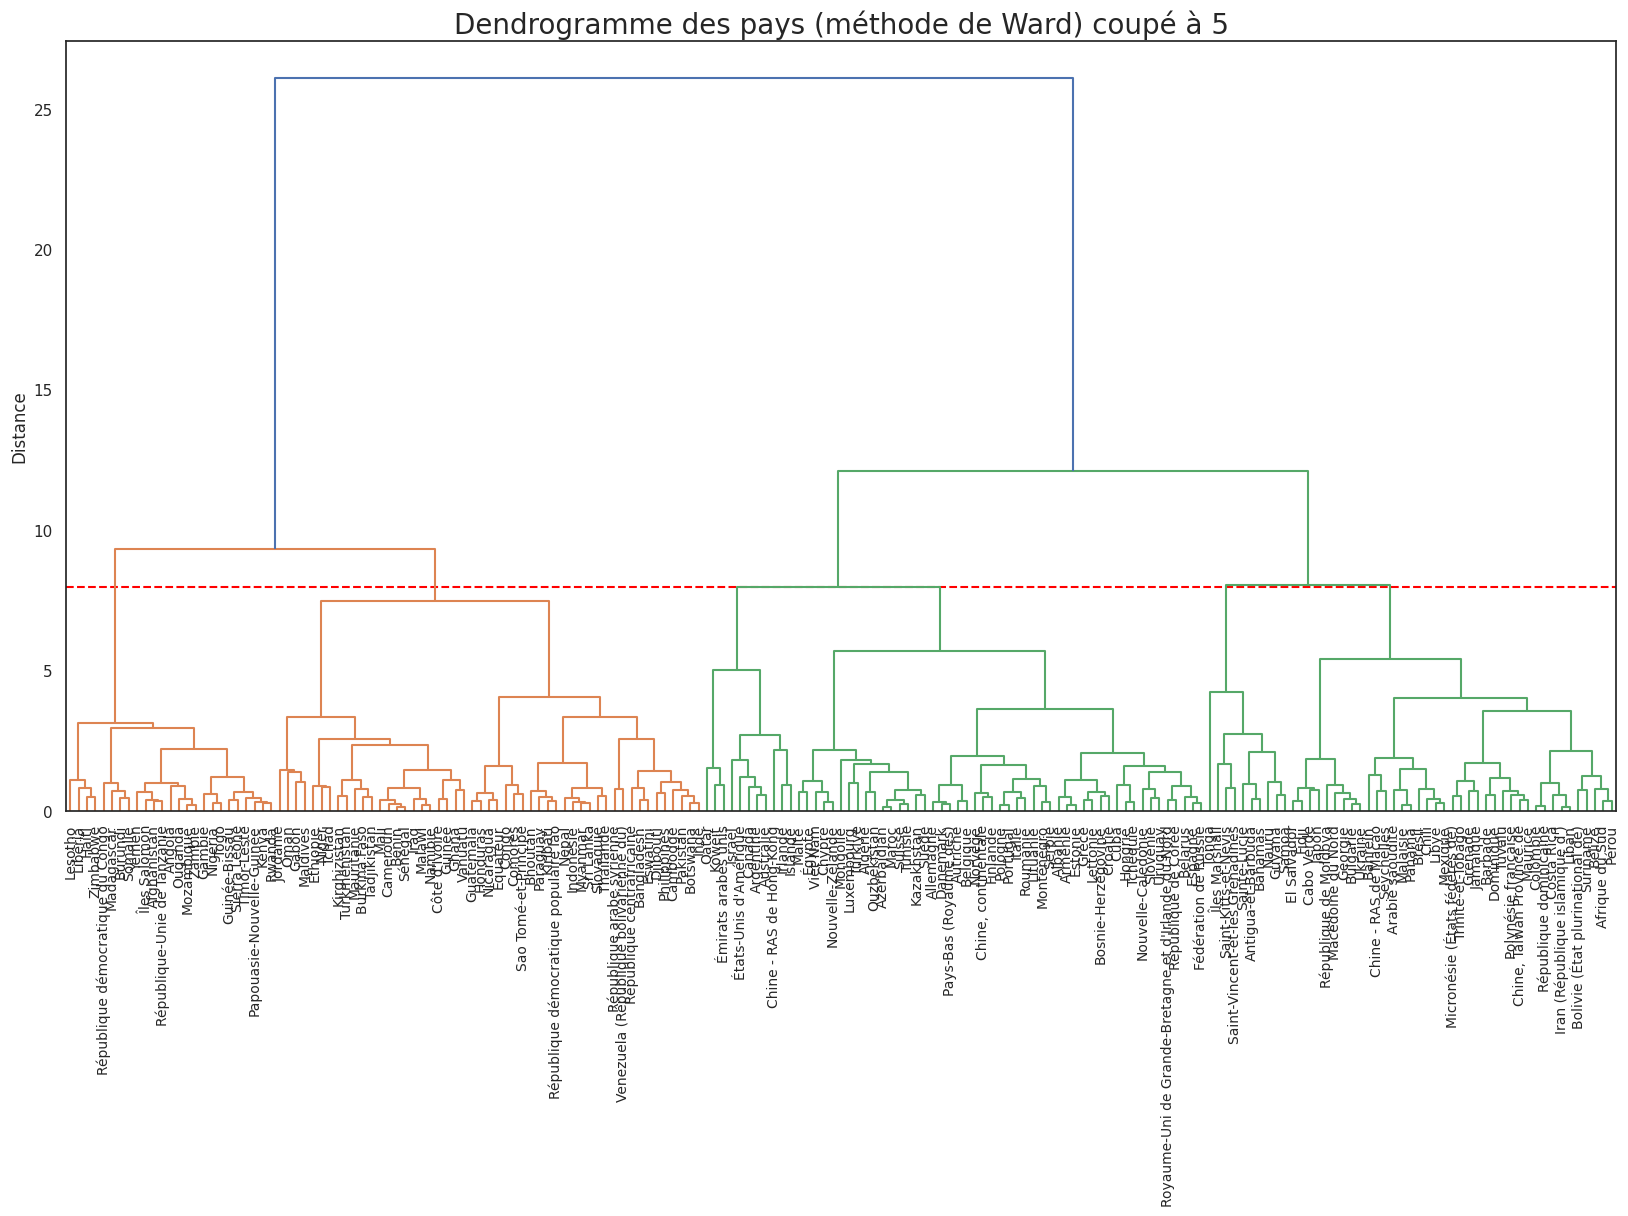

In [1004]:
plt.figure(figsize=(20, 10))
sns.set_style('white')
plt.title('Dendrogramme des pays (méthode de Ward) coupé à 5', fontsize=20)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=Z[-5, 2], c='red', ls='--')

dendrogram(Z, labels=df_dendo.index, leaf_font_size=10, orientation='top')
plt.savefig("dendrogramme.png")
plt.show()

Dendogramme tronqué

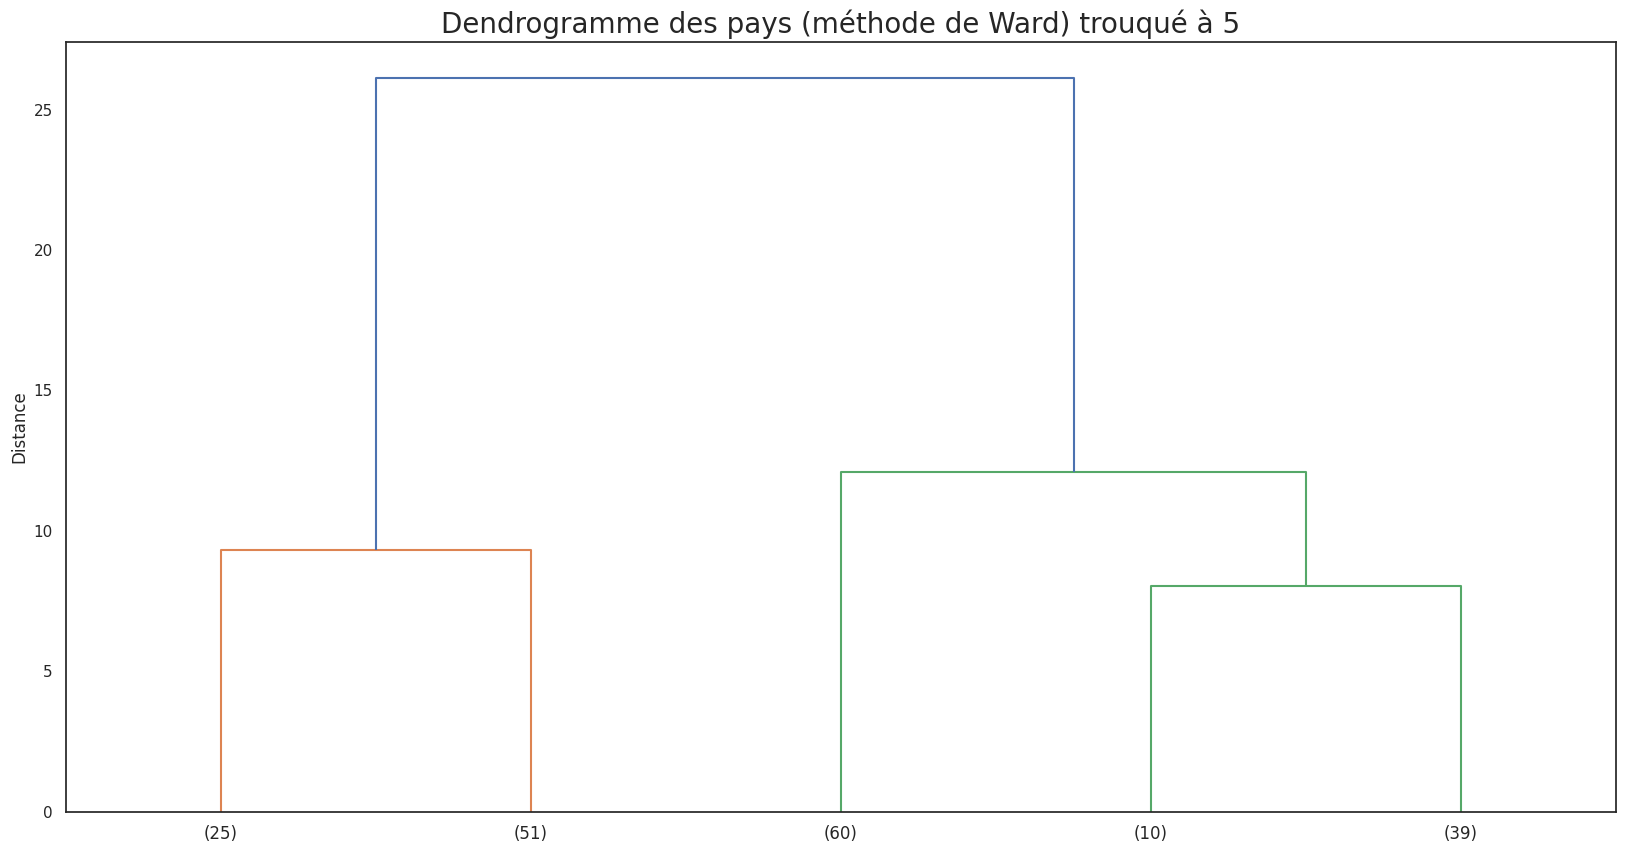

In [1005]:
plt.figure(figsize=(20, 10))
sns.set_style('white')
plt.title('Dendrogramme des pays (méthode de Ward) trouqué à 5', fontsize=20)
plt.ylabel('Distance', fontsize=12)
dendrogram(
    Z,
    truncate_mode='lastp', p= 5,
    labels = df_dendo.index
)

plt.show()

#  Caractérisation des clusters

## Répartition des pays par cluster

In [1006]:

clusters = fcluster(Z, t=5, criterion='maxclust')

df_clustered=df_dendo.copy()

df_clustered.loc[:, "cluster"] = clusters

df_clustered["cluster"].value_counts().sort_index()

cluster
1    25
2    51
3    60
4    10
5    39
Name: count, dtype: int64

In [1007]:
df_clustered.head()

poulet_g_pers_jr  proteines_total_g_pers_jr  pop_evo_ratio  \
Pays                                                                         
Afghanistan                 0.68                      61.16      36.298249   
Afrique du Sud             17.85                      82.27      16.053147   
Albanie                     5.56                     115.71      -2.124984   
Algérie                     2.78                      95.33      21.292694   
Allemagne                   4.92                     110.54       3.511359   

                kcal_total_pers_jr  cluster  
Pays                                         
Afghanistan                2239.62        1  
Afrique du Sud             2772.36        5  
Albanie                    3330.25        3  
Algérie                    3499.10        3  
Allemagne                  3620.22        3

In [1008]:
df_clustered.index.name = 'Pays'


In [1009]:
df_clustered1 = df_clustered.reset_index()
df_clustered1.head()


Pays  poulet_g_pers_jr  proteines_total_g_pers_jr  pop_evo_ratio  \
0     Afghanistan              0.68                      61.16      36.298249   
1  Afrique du Sud             17.85                      82.27      16.053147   
2         Albanie              5.56                     115.71      -2.124984   
3         Algérie              2.78                      95.33      21.292694   
4       Allemagne              4.92                     110.54       3.511359   

   kcal_total_pers_jr  cluster  
0             2239.62        1  
1             2772.36        5  
2             3330.25        3  
3             3499.10        3  
4             3620.22        3

In [1010]:
df_clustered1.to_csv("pays_groupe_dendo.csv", index=False)

files.download('pays_groupe_dendo.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  Boxplots comparatifs par cluster

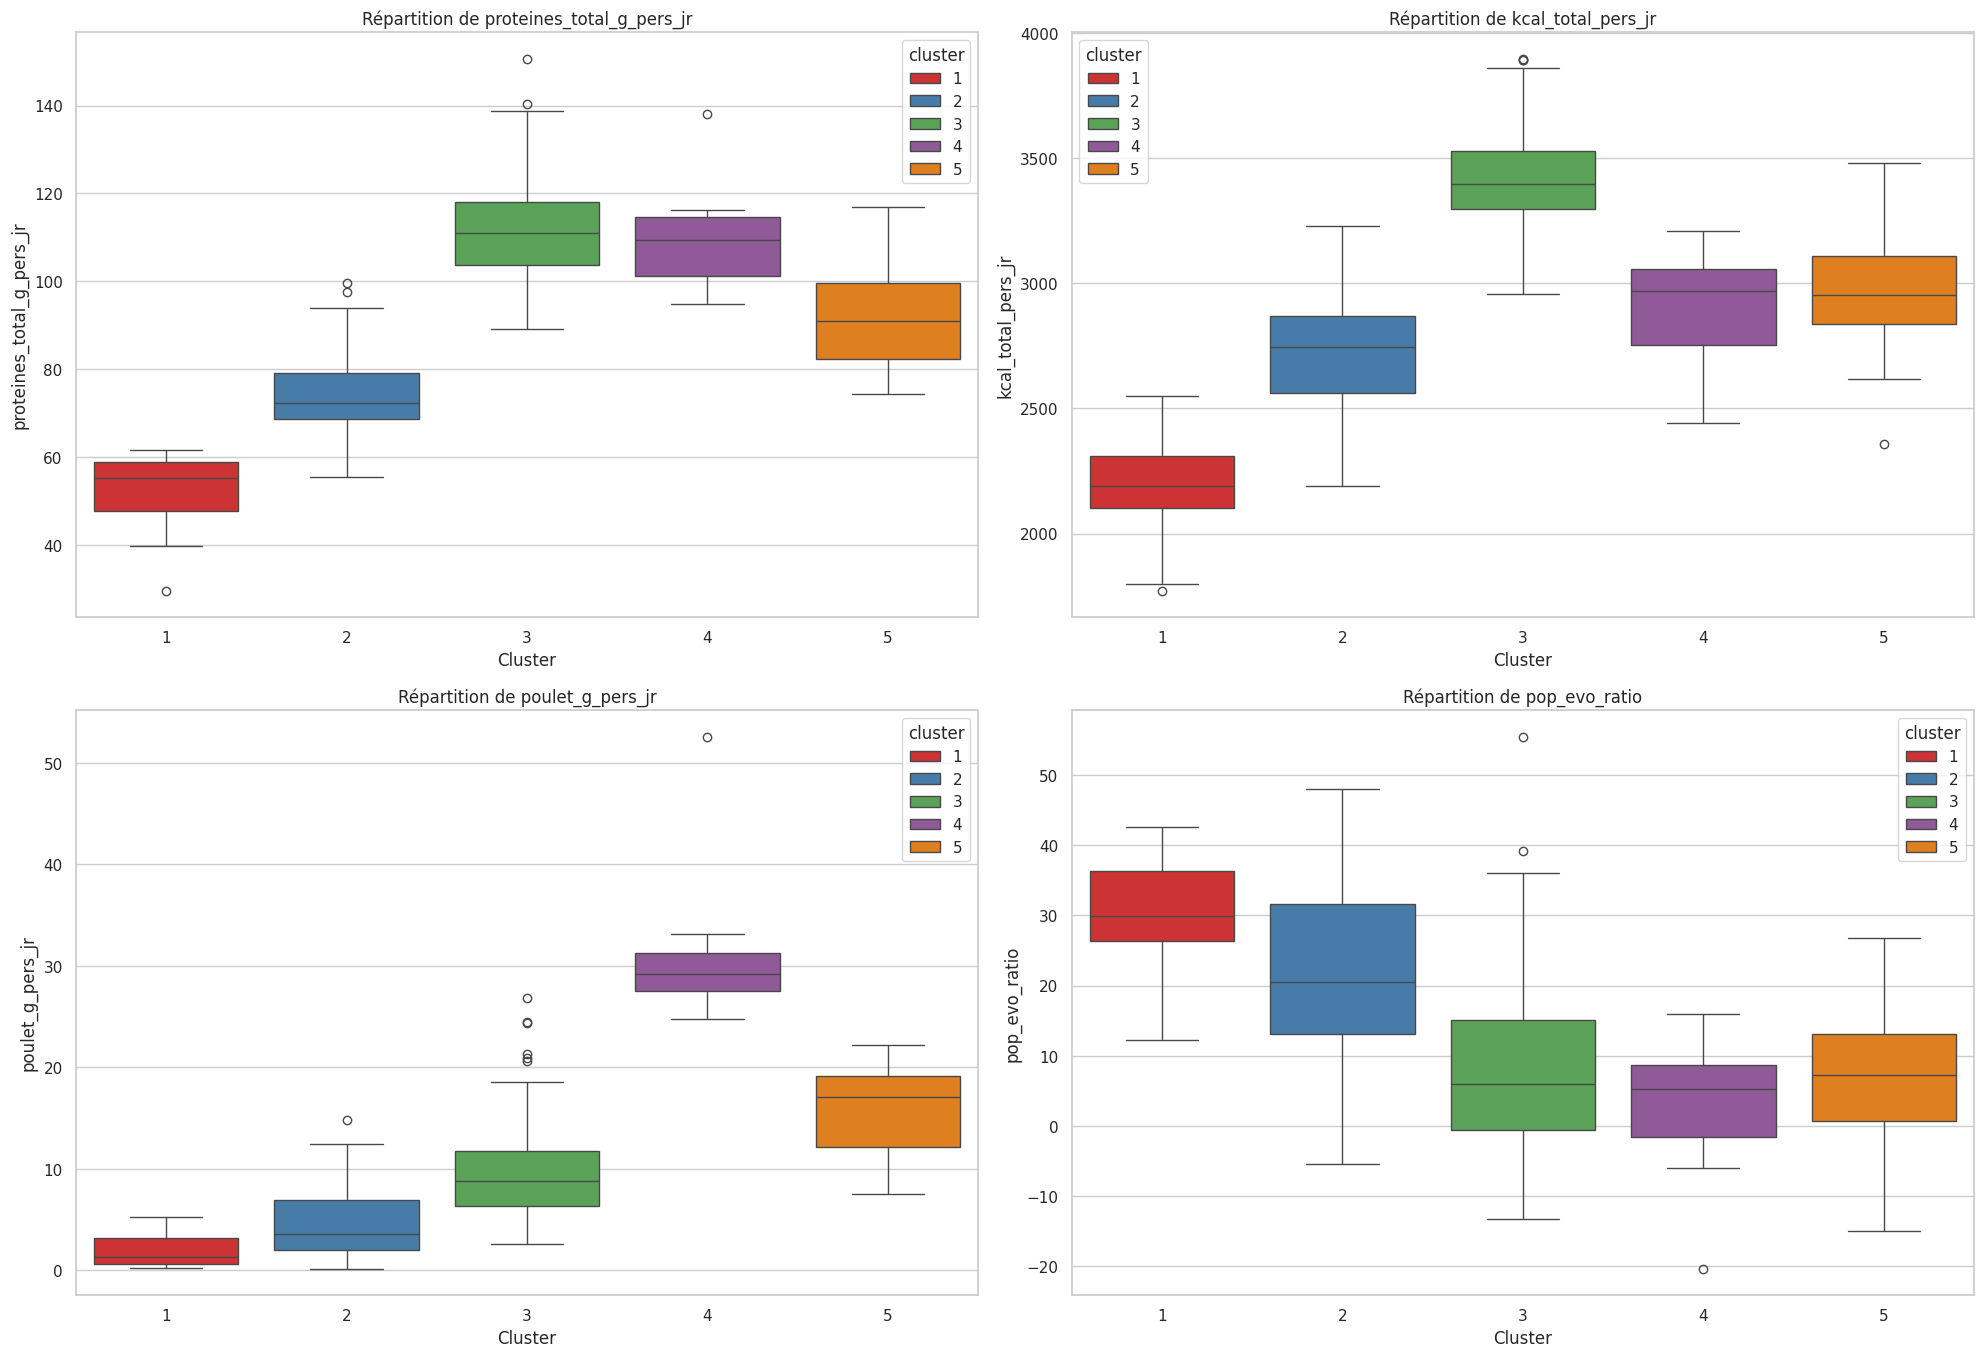

In [1011]:

variables = ["proteines_total_g_pers_jr", "kcal_total_pers_jr", "poulet_g_pers_jr", "pop_evo_ratio"]
cluster_palette = {
    1: "#e41a1c",
    2: "#377eb8",
    3: "#4daf4a",
    4: "#984ea3",
    5: "#ff7f00"
}

# Configuration du style
sns.set(style="whitegrid")

# Figure globale
plt.figure(figsize=(20, 20))

# Boucle d’affichage des boxplots
for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df_clustered, x='cluster', y=var, hue='cluster', palette=cluster_palette)
    plt.title(f'Répartition de {var}', fontsize=12)
    plt.xlabel("Cluster")
    plt.ylabel(var)

plt.tight_layout()
plt.show(block=False)

| Cluster | Apport calorique | Protéines  | Poulet      | Pop. Évolution | Profil possible                                              |
| ------- | ---------------- | ---------- | ----------- | -------------- | ------------------------------------------------------------ |
| 🟥**1**   | Faible           | Faible     | Très faible | Élevée         | Pays en développement, forte croissance démographique        |
| 🟦**2**   | Moyen            | Moyen      | Faible      | Moyenne        | Pays en transition                                           |
| 🟩  **3**   | Très élevé       | Très élevé | Moyen       | Moyenne        | Pays riches ou émergents avec régime protéique élevé         |
|  🟪 **4**   | Élevé            | Élevé      | Très élevé  | Faible         | Pays riches, forte consommation de poulet, faible croissance |
|  🟧 **5**   | Élevé            | Bon        | Élevé       | Faible         | Pays riches ou stables, alimentation variée                  |


##  Moyennes des variables par cluster

In [1012]:
df_clustered.groupby("cluster").mean(numeric_only=True)

poulet_g_pers_jr  proteines_total_g_pers_jr  pop_evo_ratio  \
cluster                                                               
1                2.020000                  52.059200      29.874011   
2                4.743725                  74.398039      21.726515   
3               10.152500                 112.586500       8.047487   
4               31.208000                 110.168000       2.409518   
5               16.023333                  91.836154       7.323356   

         kcal_total_pers_jr  
cluster                      
1               2192.822400  
2               2715.085490  
3               3419.479167  
4               2905.331000  
5               2962.556923

##  Interprétation des groupes

    
    🟥  Cluster 1 – Pays à faible niveau nutritionnel et forte croissance

* Faible apport en protéines (52 g/pers/jr) et calories (2192 kcal/pers/jr)

* Très forte croissance démographique (≈ 30 %)

* Très faible consommation de poulet (2 g/jr)

* Ratio poulet/protéines très bas (0.04)

→ Profil : **pays en développement**, sous-alimentation probable, forte pression démographique.



     🟦 Cluster 2 – Pays en transition nutritionnelle**

* Apports modérés (74 g protéines, 2715 kcal)

* Croissance démographique toujours élevée (≈ 22 %)

* Consommation modérée de poulet (4.7 g/jr)

* Ratio faible (0.065)

→ Profil : **pays en développement avancé**, en **transition** vers un régime plus riche.



     🟩 Cluster 3 – Pays riches en apport calorique et protéique

* Très fort apport nutritionnel (113 g protéines, 3420 kcal)

* Croissance démographique faible (≈ 8 %)

* Consommation importante de poulet (10.2 g/jr)

* Ratio modéré (0.09)

→ Profil : **pays développés**, alimentation diversifiée et riche.



    🟪  Cluster 4 – Pays à régime très centré sur le poulet

Protéines élevées (110 g), calories assez élevées (2905 kcal)

Croissance très faible (≈ 2.4 %)

Très forte consommation de poulet (31 g/jr !)

Ratio extrêmement élevé (0.28)

→ Profil : pays à **forte dépendance au poulet dans leur apport protéique****. Probablement USA, Brésil, pays du Golfe...




    🟧   Cluster 5 – Pays riches, poulet présent mais non dominant
* Apports élevés (92 g prot, 2960 kcal)

* Faible croissance (7.3 %)

* Consommation modérée de poulet (16 g/jr)

* Ratio intermédiaire (0.17)

→ Profil :**pays développés**, alimentation équilibrée, le **poulet est une source importante** mais pas dominante.

#  Analyse en Composantes Principales (ACP)

## Initialisation

### Standardisation des données

L’analyse en composantes principales (ACP) **réduit le nombre de dimensions dans les grands jeux de données** à des composantes principales qui conservent la plupart des informations d’origine.

Pour ce faire, elle transforme les variables potentiellement corrélées en un ensemble plus restreint de variables, appelées composantes principales.

### Extraction de la matrice de données

In [1013]:
type(X)

numpy.ndarray

#### Vérification dimensions

In [1014]:
X.shape

(185, 4)

185 pays et 4 variables

### Application du StandardScaler

Avant l’ACP ou le clustering, il est essentiel de standardiser les variables pour qu’elles aient toutes la même échelle (moyenne 0, écart-type 1).

In [1015]:
for i in range(1, 6):
    print(f"Cluster {i}:")
    print(", ".join(df_clustered[df_clustered["cluster"] == i].index.sort_values()))
    print()


Cluster 1:
Afghanistan, Angola, Burundi, Gambie, Guinée-Bissau, Haïti, Kenya, Lesotho, Libéria, Madagascar, Mozambique, Nigéria, Ouganda, Papouasie-Nouvelle-Guinée, Rwanda, République démocratique du Congo, République-Unie de Tanzanie, Sierra Leone, Somalie, Timor-Leste, Togo, Yémen, Zambie, Zimbabwe, Îles Salomon

Cluster 2:
Bangladesh, Bhoutan, Botswana, Burkina Faso, Bénin, Cambodge, Cameroun, Comores, Congo, Côte d'Ivoire, Djibouti, Eswatini, Gabon, Ghana, Guatemala, Guinée, Honduras, Inde, Indonésie, Iraq, Jordanie, Kirghizistan, Kiribati, Malawi, Maldives, Mali, Mauritanie, Myanmar, Namibie, Nicaragua, Niger, Népal, Oman, Pakistan, Paraguay, Philippines, République arabe syrienne, République centrafricaine, République démocratique populaire lao, Sao Tomé-et-Principe, Slovaquie, Sri Lanka, Sénégal, Tadjikistan, Tchad, Thaïlande, Turkménistan, Vanuatu, Venezuela (République bolivarienne du), Équateur, Éthiopie

Cluster 3:
Albanie, Algérie, Allemagne, Argentine, Arménie, Australie, 

In [1016]:
names = df_clustered.index
names

Index(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine',
       'Arménie',
       ...
       'Yémen', 'Zambie', 'Zimbabwe', 'Égypte', 'Émirats arabes unis',
       'Équateur', 'États-Unis d'Amérique', 'Éthiopie', 'Îles Marshall',
       'Îles Salomon'],
      dtype='object', name='Pays', length=185)

In [1017]:
features = ['proteines_total_g_pers_jr', 'kcal_total_pers_jr', 'pop_evo_ratio', 'poulet_g_pers_jr']



In [1018]:

X=df_clustered[features]

In [1019]:
scaler = StandardScaler()


In [1020]:
scaler.fit(X)

StandardScaler()

In [1021]:
X_scaled = scaler.transform(X)

X_scaled = scaler.fit_transform(X)

In [1022]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3
mean  0.0  0.0 -0.0 -0.0
std   1.0  1.0  1.0  1.0

Les données ont été correctement standardisées.

Chaque variable a désormais une moyenne centrée à 0,

Et un écart-type normalisé à 1.

### Ebouli des valeurs Propres




In [1023]:
n_components = 4

In [1024]:
pca =PCA(n_components=n_components)


In [1025]:
pca.fit(X_scaled)

PCA(n_components=4)

In [1026]:
pca.explained_variance_ratio_

array([0.62677208, 0.1838471 , 0.15932877, 0.03005205])

In [1027]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([62.68, 18.38, 15.93,  3.01])

- **PC1 (1ʳᵉ composante)** : 62.68%
- **PC2 (2ᵉ composante)** : 18.38%
- **PC3 (3ᵉ composante)** : 15.93%
- **PC4** : 3.01%




In [1028]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4]

In [1029]:
pcs = pca.components_
pcs

array([[ 0.58660003,  0.54451719, -0.43991707,  0.40727682],
       [-0.12940474, -0.44500731,  0.09252581,  0.88128423],
       [ 0.30519622,  0.31175812,  0.8932523 ,  0.10845489],
       [ 0.73892496, -0.6389651 , -0.00350318, -0.21377849]])

In [1030]:
pcs = pd.DataFrame(pcs)
test = pd.DataFrame(pcs)
pcs

0         1         2         3
0  0.586600  0.544517 -0.439917  0.407277
1 -0.129405 -0.445007  0.092526  0.881284
2  0.305196  0.311758  0.893252  0.108455
3  0.738925 -0.638965 -0.003503 -0.213778

**Ebouli des valeurs Propres**

L'éboulis des valeurs propres permet de déterminer le nombre optimal de composantes principales à conserver dans une ACP.
Chaque barre représente la part d'inertie (variance) expliquée par une composante.
L’objectif est de réduire la dimension des données tout en conservant un maximum d’information.
En identifiant un “coude” sur la courbe, on repère le point au-delà duquel les composantes supplémentaires n’apportent que peu de variance supplémentaire.

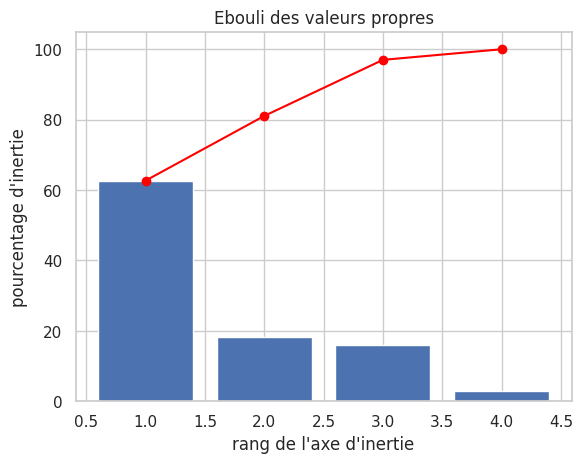

In [1031]:
scree = [62.68, 18.38, 15.93,  3.01]
scree_cum = [sum(scree[:i+1]) for i in range(len(scree))]


x_list = range(1, len(scree) + 1)

# Tracé
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker="o")
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Ebouli des valeurs propres")
plt.show()


La première composante explique à elle seule environ 63 % de la variance.

Les deux premières cumulent plus de 80 % de l’information totale.

Après la troisième composante, les gains deviennent marginaux.

Ainsi, 2 ou 3 composantes principales suffisent pour une visualisation efficace des données en 2D ou 3D.

Ce choix garantit une bonne lisibilité des clusters tout en préservant la structure des données.

##  Lancement de l’ACP

### Variance expliquée

In [1032]:

#features = ['proteines_total_g_pers_jr', 'kcal_total_pers_jr', 'poulet_g_pers_jr', 'pop_evo_ratio']
#X = df_clustered[features].dropna()

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)


In [1033]:
#pca = PCA(n_components=4)
#X_proj = pca.fit_transform(X_scaled)


In [1034]:
pcs.columns = features
pcs.index = [f"PC{i}" for i in x_list]
pcs.round(2)


proteines_total_g_pers_jr  kcal_total_pers_jr  pop_evo_ratio  \
PC1                       0.59                0.54          -0.44   
PC2                      -0.13               -0.45           0.09   
PC3                       0.31                0.31           0.89   
PC4                       0.74               -0.64          -0.00   

     poulet_g_pers_jr  
PC1              0.41  
PC2              0.88  
PC3              0.11  
PC4             -0.21

In [1035]:
pcs.T

PC1       PC2       PC3       PC4
proteines_total_g_pers_jr  0.586600 -0.129405  0.305196  0.738925
kcal_total_pers_jr         0.544517 -0.445007  0.311758 -0.638965
pop_evo_ratio             -0.439917  0.092526  0.893252 -0.003503
poulet_g_pers_jr           0.407277  0.881284  0.108455 -0.213778

L'Analyse en Composantes Principales (ACP) révèle les axes suivants :

- **PC1 (61.2%)** : reflète un **niveau nutritionnel général élevé** (protéines, calories, poulet) **opposé à la croissance démographique**. Il distingue clairement les pays riches en ressources alimentaires.


- **PC2 (18.3%)** : oppose les pays à forte **croissance démographique** à ceux à plus forte **consommation de poulet**, ce qui peut refléter des différences de transition nutritionnelle.


- **PC3 (15.9%)** :met en valeur la **quantité de poulet consommée** indépendamment des autres variables — il capte spécifiquement la place du poulet dans le régime..


- **PC4 (8.3%)** : distingue les pays à **forte densité protéique** (nutrition de qualité) de ceux à **fort apport calorique** (quantité).


**Implication stratégique** : les pays situés dans la zone haute droite **(PC1 / PC2)** combinent une bonne alimentation globale et une forte consommation de poulet – ils sont donc particulièrement **pertinents pour l’export**.


Les pays situés dans la zone **PC1 / PC3** Cette projection offre un **angle complémentaire** pour repérer les marchés où le poulet est déjà central, ce qui peut orienter des actions plus ciblées ou des volumes plus importants..

### Matrice de corélation

<Axes: >

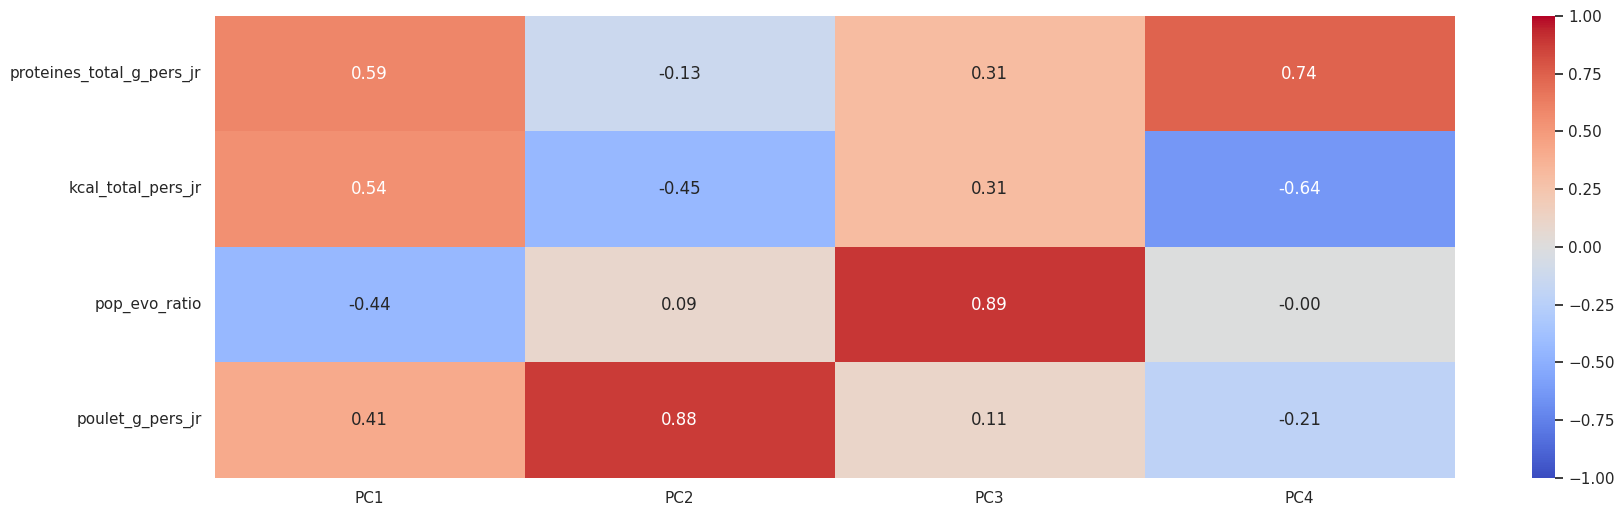

In [1036]:
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")

### Cercle de corrélation

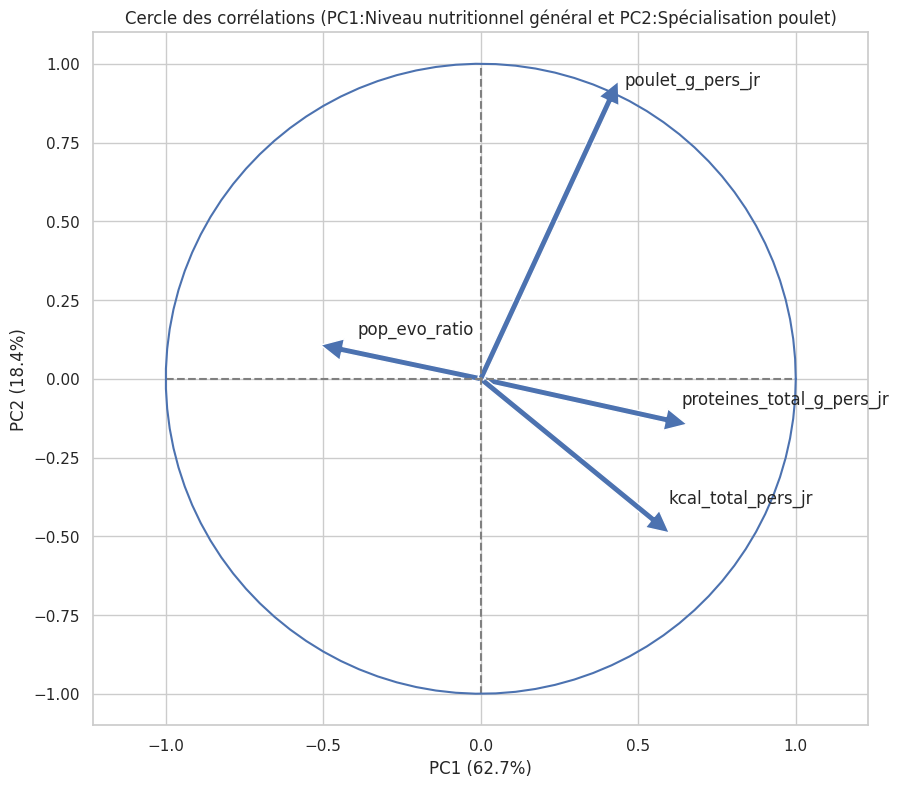

In [1037]:
x, y = 0,1
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07,
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])


plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


plt.xlabel('PC{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('PC{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (PC{}:Niveau nutritionnel général et PC{}:Spécialisation poulet)".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
plt.axis('equal')
plt.show(block=False)


**Interprétation**


* **Droite – Haut**
  * Pays riches, bien nourris, et grands consommateurs de poulet
  * Marchés cibles prioritaires (premium + volume)


* **Droite – Bas**:
  * Pays riches, nutrition élevée, mais poulet moins
  * Cibles potentielles avec approche différenciée


* **Gauche – Haut**
  * Pays à apport modeste, mais intérêt croissant pour la volaille
  * Marchés émergents avec potentiel moyen terme

* **Gauche – Bas**:
  * Faible niveau nutritionnel et faible consommation de poulet, forte croissance démographique
  * Marchés à fort potentiel long terme, mais pas prioritaires aujourd’hui


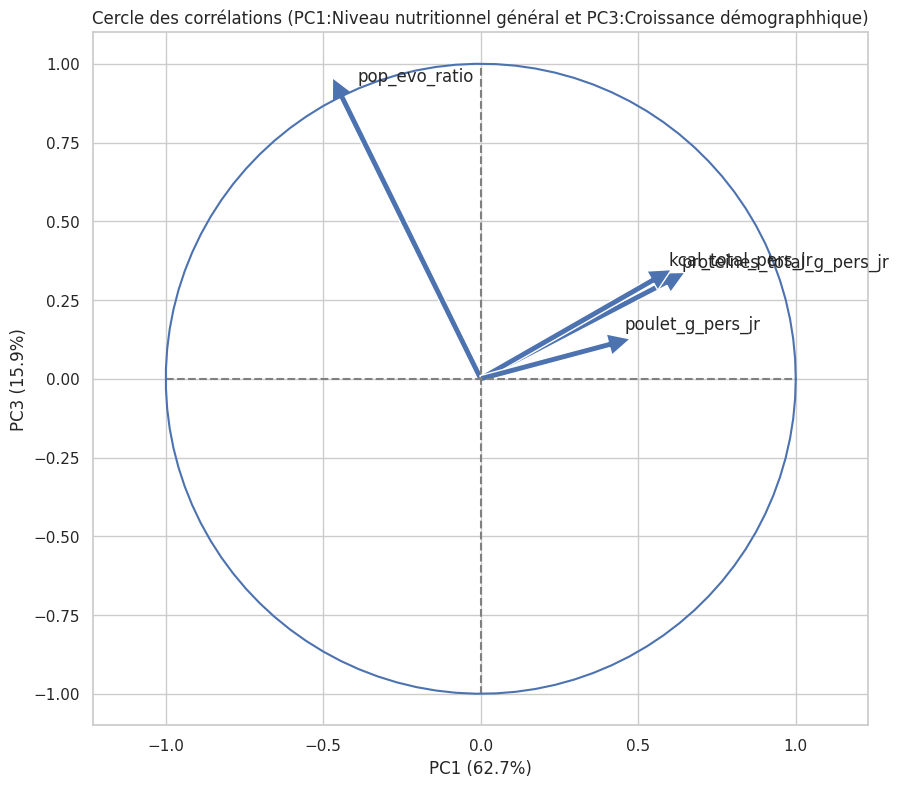

In [1038]:
x, y = 0,2
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,
             pca.components_[0, i],
             pca.components_[2, i],
             head_width=0.07,
             head_length=0.07,
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[2, i] + 0.05,
             features[i])


plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')



plt.xlabel('PC{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('PC{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (PC{}:Niveau nutritionnel général et PC{}:Croissance démographhique)".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))
plt.axis('equal')
plt.show(block=False)

**Interprétation**


* **Haut – Droite**
  * Pays bien nourris avec forte croissance démographique
  *	Marchés à très fort potentiel (à la fois demande actuelle et future)


 * **Bas – Droite**
   *	Pays riches, bien nourris, mais à population stable ou en déclin
   * Marchés matures, stables mais sans croissance démographique (type UE, Japon)

 * **Haut – Gauche**
    *	Pays en développement avec forte croissance mais apport nutritionnel faible
    * Marchés futurs : logistique + adaptation produits à envisager

 * **Bas – Gauche**
    *	Pays en difficulté (faible nutrition et croissance faible ou négative)
    * Pas de priorité immédiate, sauf stratégie humanitaire ou à très long terme

In [1039]:
df_clustered

poulet_g_pers_jr  proteines_total_g_pers_jr  \
Pays                                                                 
Afghanistan                        0.68                      61.16   
Afrique du Sud                    17.85                      82.27   
Albanie                            5.56                     115.71   
Algérie                            2.78                      95.33   
Allemagne                          4.92                     110.54   
...                                 ...                        ...   
Équateur                          12.41                      69.00   
États-Unis d'Amérique             20.66                     122.10   
Éthiopie                           0.18                      76.83   
Îles Marshall                     29.38                     114.74   
Îles Salomon                       3.21                      58.96   

                       pop_evo_ratio  kcal_total_pers_jr  cluster  
Pays                                                               
Afghanistan                36.298249             2239.62        1  
Afrique du Sud             16.053147             2772.36        5  
Albanie                    -2.124984             3330.25        3  
Algérie                    21.292694             3499.10        3  
Allemagne                   3.511359             3620.22        3  
...                              ...                 ...      ...  
Équateur                   15.373823             2561.75        2  
États-Unis d'Amérique       8.295429             3892.91        3  
Éthiopie                   31.120373             2463.44        2  
Îles Marshall             -20.305546             3208.40        4  
Îles Salomon               37.914440             2311.29        1  

[185 rows x 5 columns]

## Visualisation des clusters dans l’ACP

Petit rappel:

In [1040]:
df_clustered2 = df_clustered.copy()

In [1041]:
df_clustered2.groupby('cluster').mean()

poulet_g_pers_jr  proteines_total_g_pers_jr  pop_evo_ratio  \
cluster                                                               
1                2.020000                  52.059200      29.874011   
2                4.743725                  74.398039      21.726515   
3               10.152500                 112.586500       8.047487   
4               31.208000                 110.168000       2.409518   
5               16.023333                  91.836154       7.323356   

         kcal_total_pers_jr  
cluster                      
1               2192.822400  
2               2715.085490  
3               3419.479167  
4               2905.331000  
5               2962.556923

* **Cluster 1** :

Pays à faibles ressources nutritionnelles (protéines et calories).
Croissance démographique élevée, mais PIB très bas. Besoins alimentaires importants mais faible pouvoir d’achat → non cible immédiate, mais à surveiller.

* **Cluster 2** :

Démographie dynamique et alimentation modeste.
PIB faible, mais un peu plus de ressources que cluster 1.
Potentiel marché en croissance, mais encore limité.


* **Cluster 3** :

Marché développé : très haut niveau de protéines (surtout animales), calories, fort pouvoir d’achat.


* **Cluster 4** :

Pays riches et stables, bons apports nutritionnels.
Pas de croissance démographique → marché stable.
Potentiel intéressant si niche premium, mais moins dynamique.


* **Cluster 5** :

Bon compromis : croissance démographique, bonne nutrition, pouvoir d’achat intermédiaire.
Cible idéale pour le développement d’un marché poulet/animal.

In [1042]:
#for i in range(1, 6):
    #print(f"Cluster {i} :")
    #print(df_clustered[df_clustered['cluster'] == i].index.tolist()[:5])


### Scatterplot PCA coloré par cluster

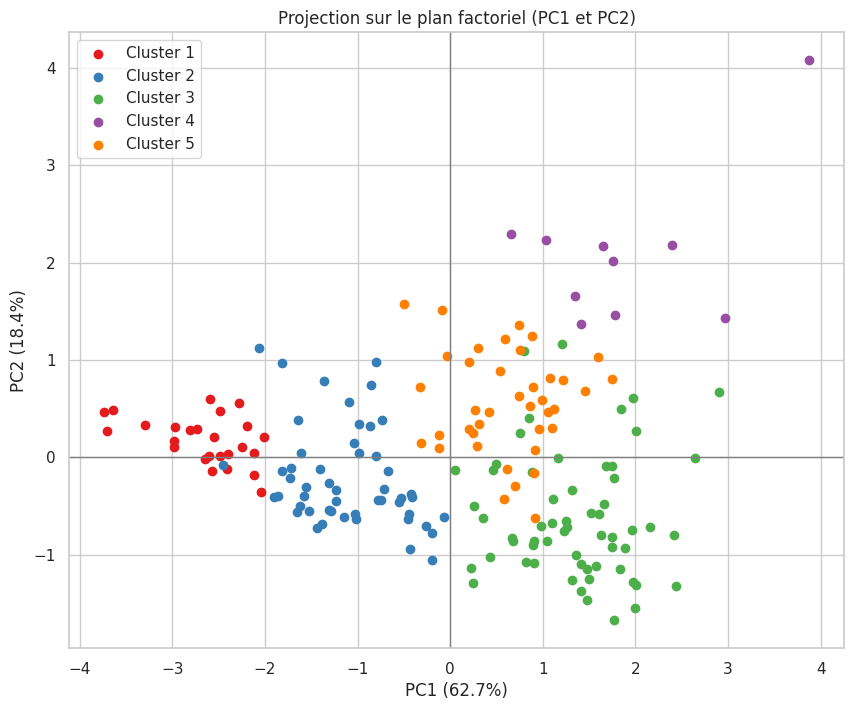

In [1043]:

cluster_palette = {
    1: "#e41a1c",
    2: "#377eb8",
    3: "#4daf4a",
    4: "#984ea3",
    5: "#ff7f00"
}


fig, ax = plt.subplots(figsize=(10, 8))

for cluster_id, color in cluster_palette.items():
    idx = df_clustered['cluster'] == cluster_id
    ax.scatter(
        X_proj[idx, 0],  # PC1
        X_proj[idx, 1],  # PC2
        label=f'Cluster {cluster_id}',
        c=color,
        marker='o'
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('Projection sur le plan factoriel (PC1 et PC2)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)
ax.legend()
plt.grid(True)
plt.show()


Vision supplémentaire facultative avec PC1-PC3

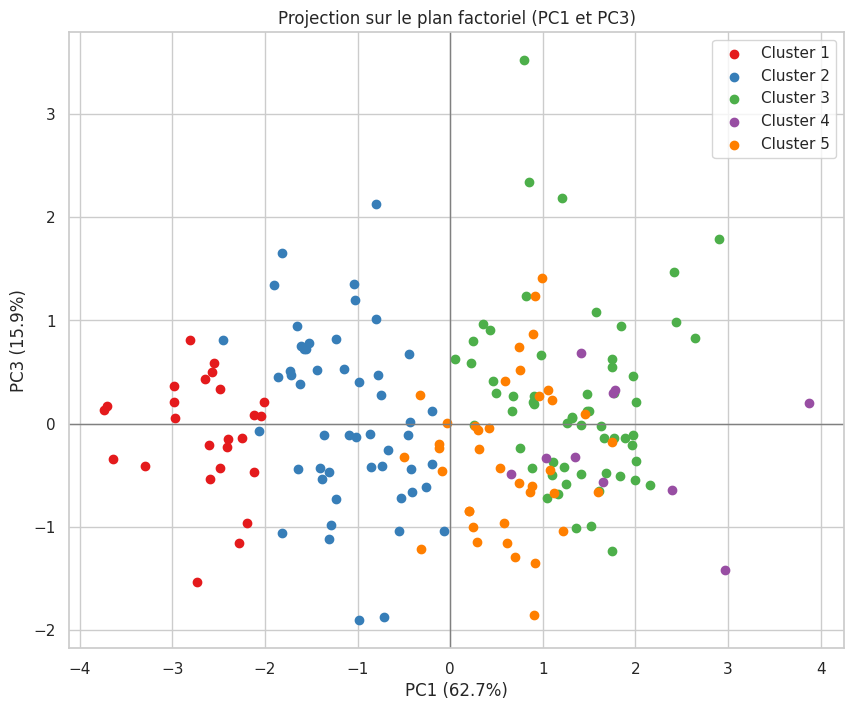

In [1044]:

cluster_palette = {
    1: "#e41a1c",
    2: "#377eb8",
    3: "#4daf4a",
    4: "#984ea3",
    5: "#ff7f00"
}


fig, ax = plt.subplots(figsize=(10, 8))

for cluster_id, color in cluster_palette.items():
    idx = df_clustered['cluster'] == cluster_id
    ax.scatter(
        X_proj[idx, 0],  # PC
        X_proj[idx, 2],
        label=f'Cluster {cluster_id}',
        c=color,
        marker='o'
    )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('Projection sur le plan factoriel (PC1 et PC3)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)
ax.legend()
plt.grid(True)
plt.show()

###  Affichage des centroïdes

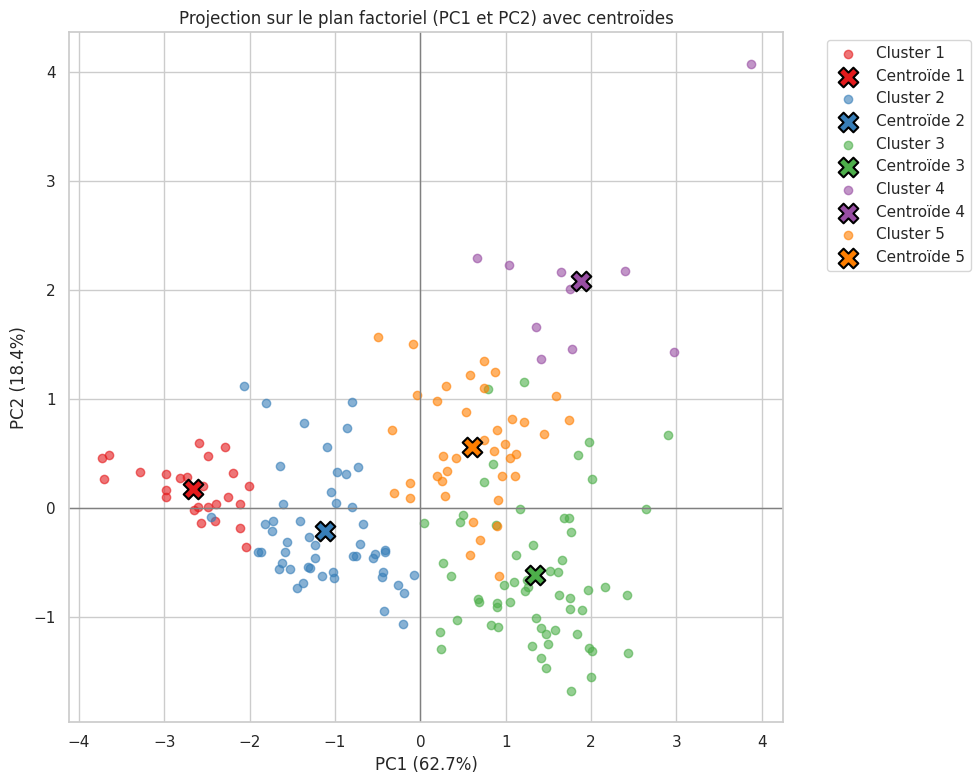

In [1045]:

cluster_palette = {
    1: "#e41a1c",
    2: "#377eb8",
    3: "#4daf4a",
    4: "#984ea3",
    5: "#ff7f00"
}

fig, ax = plt.subplots(figsize=(10, 8))


for cluster_id, color in cluster_palette.items():
    idx = df_clustered['cluster'] == cluster_id
    ax.scatter(
        X_proj[idx, 0],  # PC
        X_proj[idx, 1],
        label=f'Cluster {cluster_id}',
        c=color,
        marker='o',
        alpha=0.6
    )


    centroid_x = X_proj[idx, 0].mean()
    centroid_y = X_proj[idx, 1].mean()
    ax.scatter(
        centroid_x,
        centroid_y,
        c=color,
        marker='X',
        s=200,
        edgecolors='black',
        linewidths=1.5,
        label=f'Centroïde {cluster_id}'
    )


ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('Projection sur le plan factoriel (PC1 et PC2) avec centroïdes')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

plt.show()


Visualition complémentaire PC1- PC3:

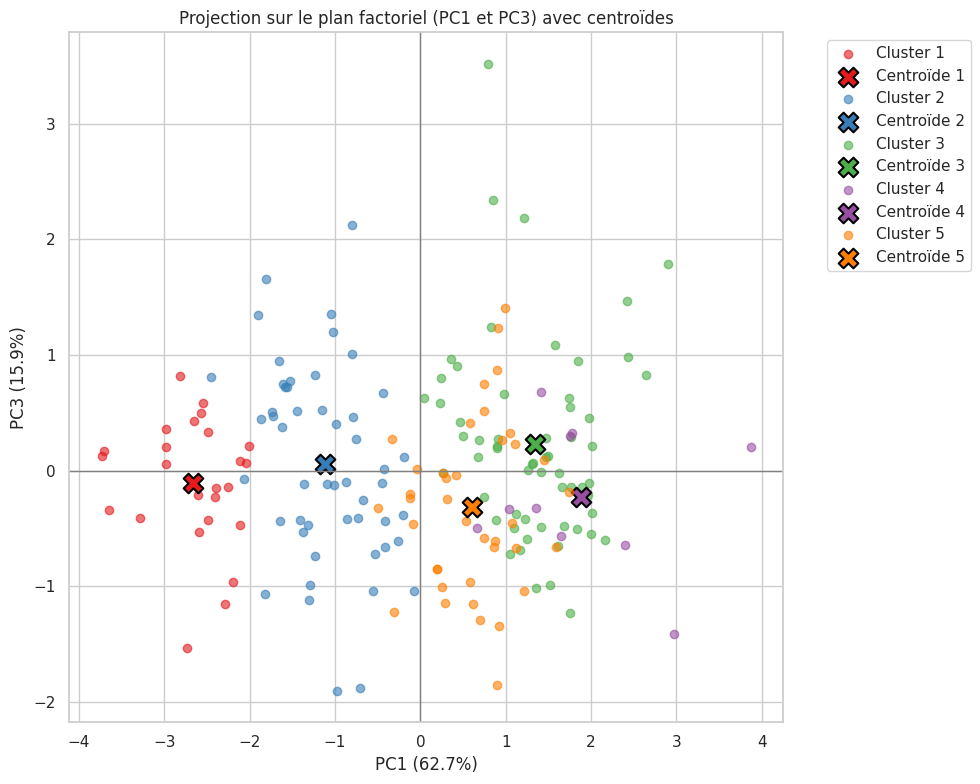

In [1046]:

cluster_palette = {
    1: "#e41a1c",
    2: "#377eb8",
    3: "#4daf4a",
    4: "#984ea3",
    5: "#ff7f00"
}

fig, ax = plt.subplots(figsize=(10, 8))


for cluster_id, color in cluster_palette.items():
    idx = df_clustered['cluster'] == cluster_id
    ax.scatter(
        X_proj[idx, 0],  # PC2
        X_proj[idx, 2],  # PC3
        label=f'Cluster {cluster_id}',
        c=color,
        marker='o',
        alpha=0.6
    )


    centroid_x = X_proj[idx, 0].mean()
    centroid_y = X_proj[idx, 2].mean()
    ax.scatter(
        centroid_x,
        centroid_y,
        c=color,
        marker='X',
        s=200,
        edgecolors='black',
        linewidths=1.5,
        label=f'Centroïde {cluster_id}'
    )


ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('Projection sur le plan factoriel (PC1 et PC3) avec centroïdes')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


### Affichage par nom des pays

In [1047]:
def display_factorial_planes2(X_proj, x_y, pca, labels=None, clusters=None, palette=None, alpha=1, marker='o', figsize=(10, 8)):
    """
    Affiche la projection des individus sur un plan factoriel de l'ACP.

    Arguments :
    - X_proj : ndarray, coordonnées des individus dans le nouvel espace
    - x_y : tuple ou liste, deux indices des axes principaux (ex: [0, 1] pour PC1 vs PC2)
    - pca : objet PCA (de scikit-learn), pour récupérer la variance expliquée
    - labels : noms des individus (facultatif)
    - clusters : Series ou array, pour colorer les points selon des groupes (facultatif)
    - palette : dict, dictionnaire des couleurs par cluster (facultatif)
    - alpha : transparence des points
    - marker : style du point
    - figsize : taille de la figure
    """

    x, y = x_y[0], x_y[1]
    plt.figure(figsize=figsize)

    # Affichage des points
    if clusters is not None:
        unique_clusters = sorted(set(clusters))
        for cluster_id in unique_clusters:
            indices = (clusters == cluster_id)
            color = palette.get(cluster_id, None) if palette else None
            plt.scatter(
                X_proj[indices, x],
                X_proj[indices, y],
                label=f"Cluster {cluster_id}",
                alpha=alpha,
                marker=marker,
                c=color
            )
    else:
        plt.scatter(X_proj[:, x], X_proj[:, y], alpha=alpha, marker=marker)

    # Ajout des labels (noms des pays par ex.)
    if labels is not None:
        for i, label in enumerate(labels):
            plt.text(X_proj[i, x], X_proj[i, y], label, fontsize=9, alpha=0.7)

    # Axes
    plt.axhline(0, color='grey', lw=1)
    plt.axvline(0, color='grey', lw=1)
    plt.xlabel(f'PC{x+1} ({pca.explained_variance_ratio_[x]*100:.1f}%)')
    plt.ylabel(f'PC{y+1} ({pca.explained_variance_ratio_[y]*100:.1f}%)')
    plt.title(f'Projection des individus (PC{x+1} et PC{y+1})')
    plt.legend()
    plt.grid(True)
    plt.show()


**PC1-PC2**

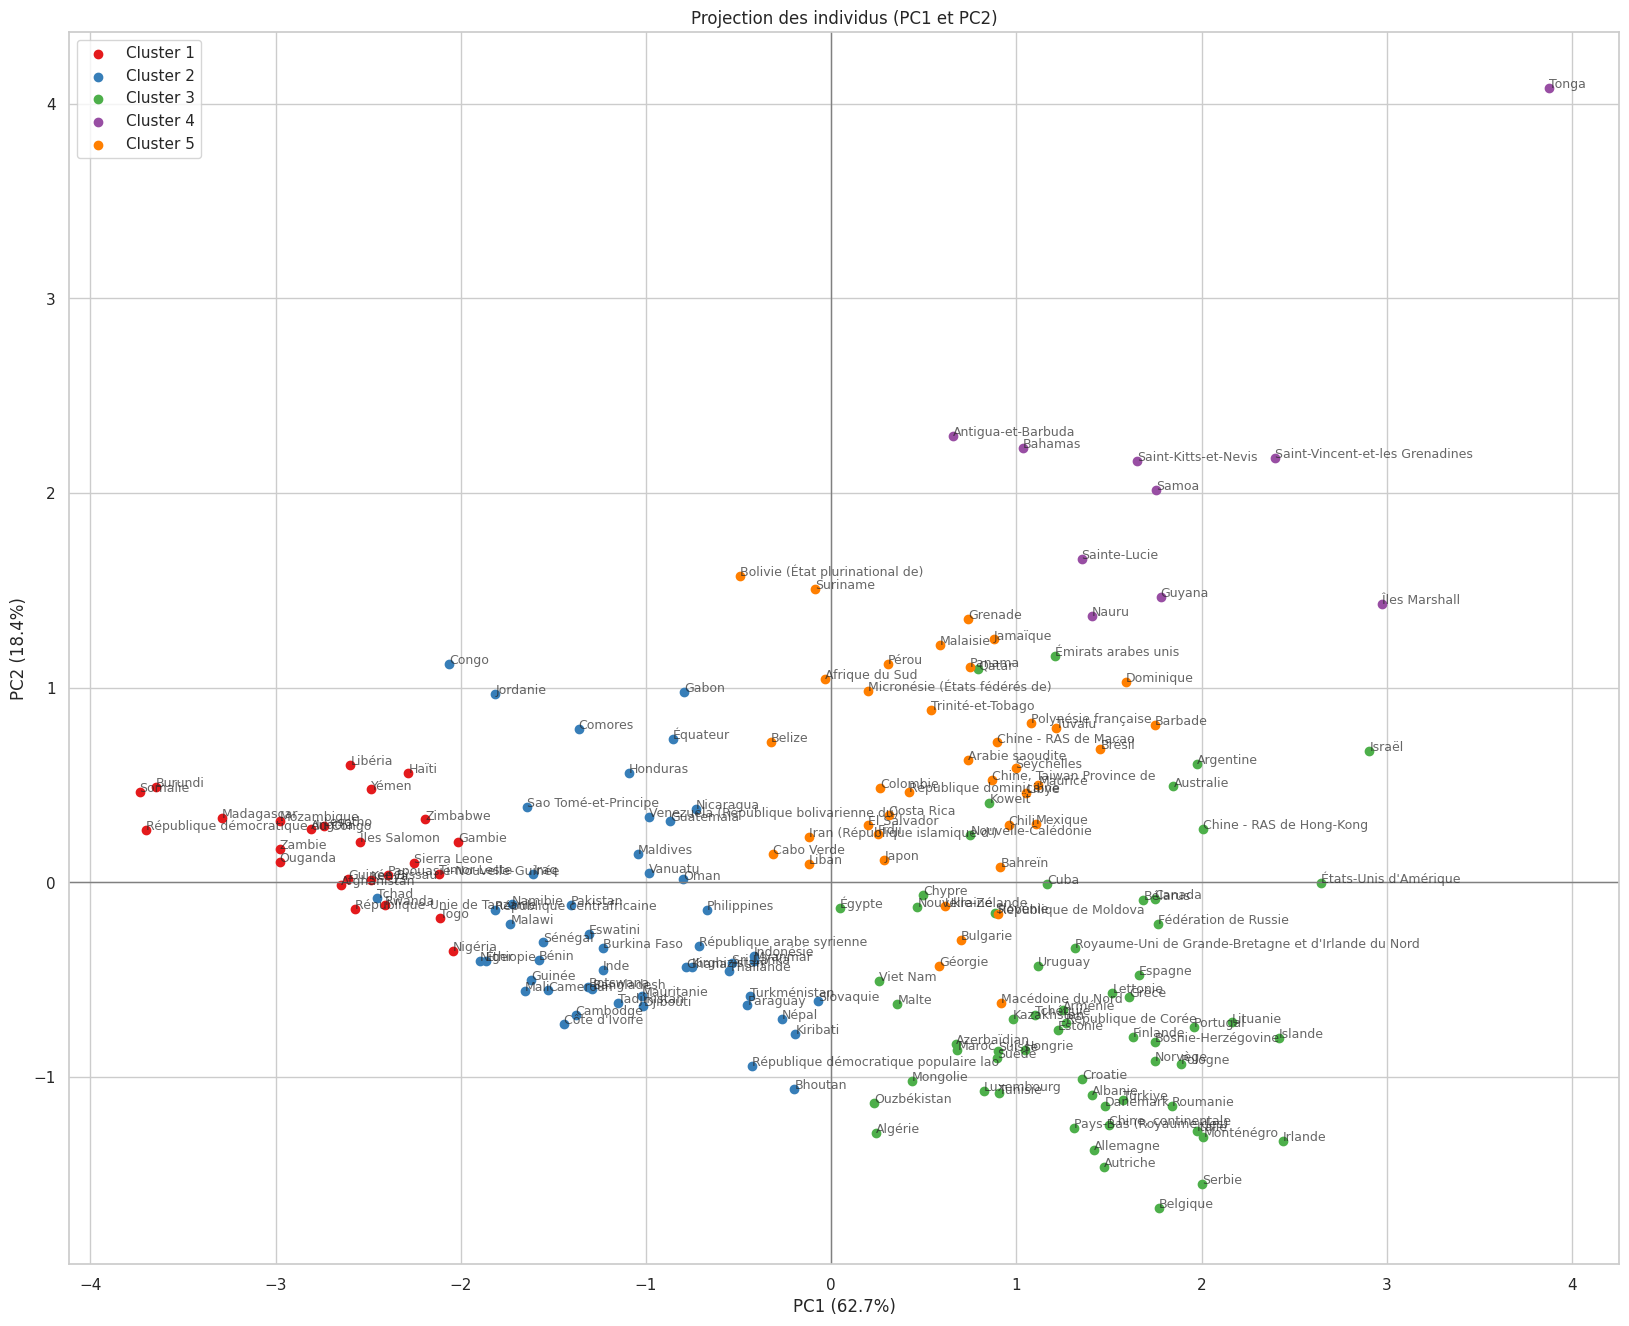

In [1048]:
x_y = 0,1
display_factorial_planes2(X_proj, x_y, pca, labels=names, figsize=(20,16), clusters=df_clustered['cluster'], palette=cluster_palette, marker="o")

** PC1- PC3**

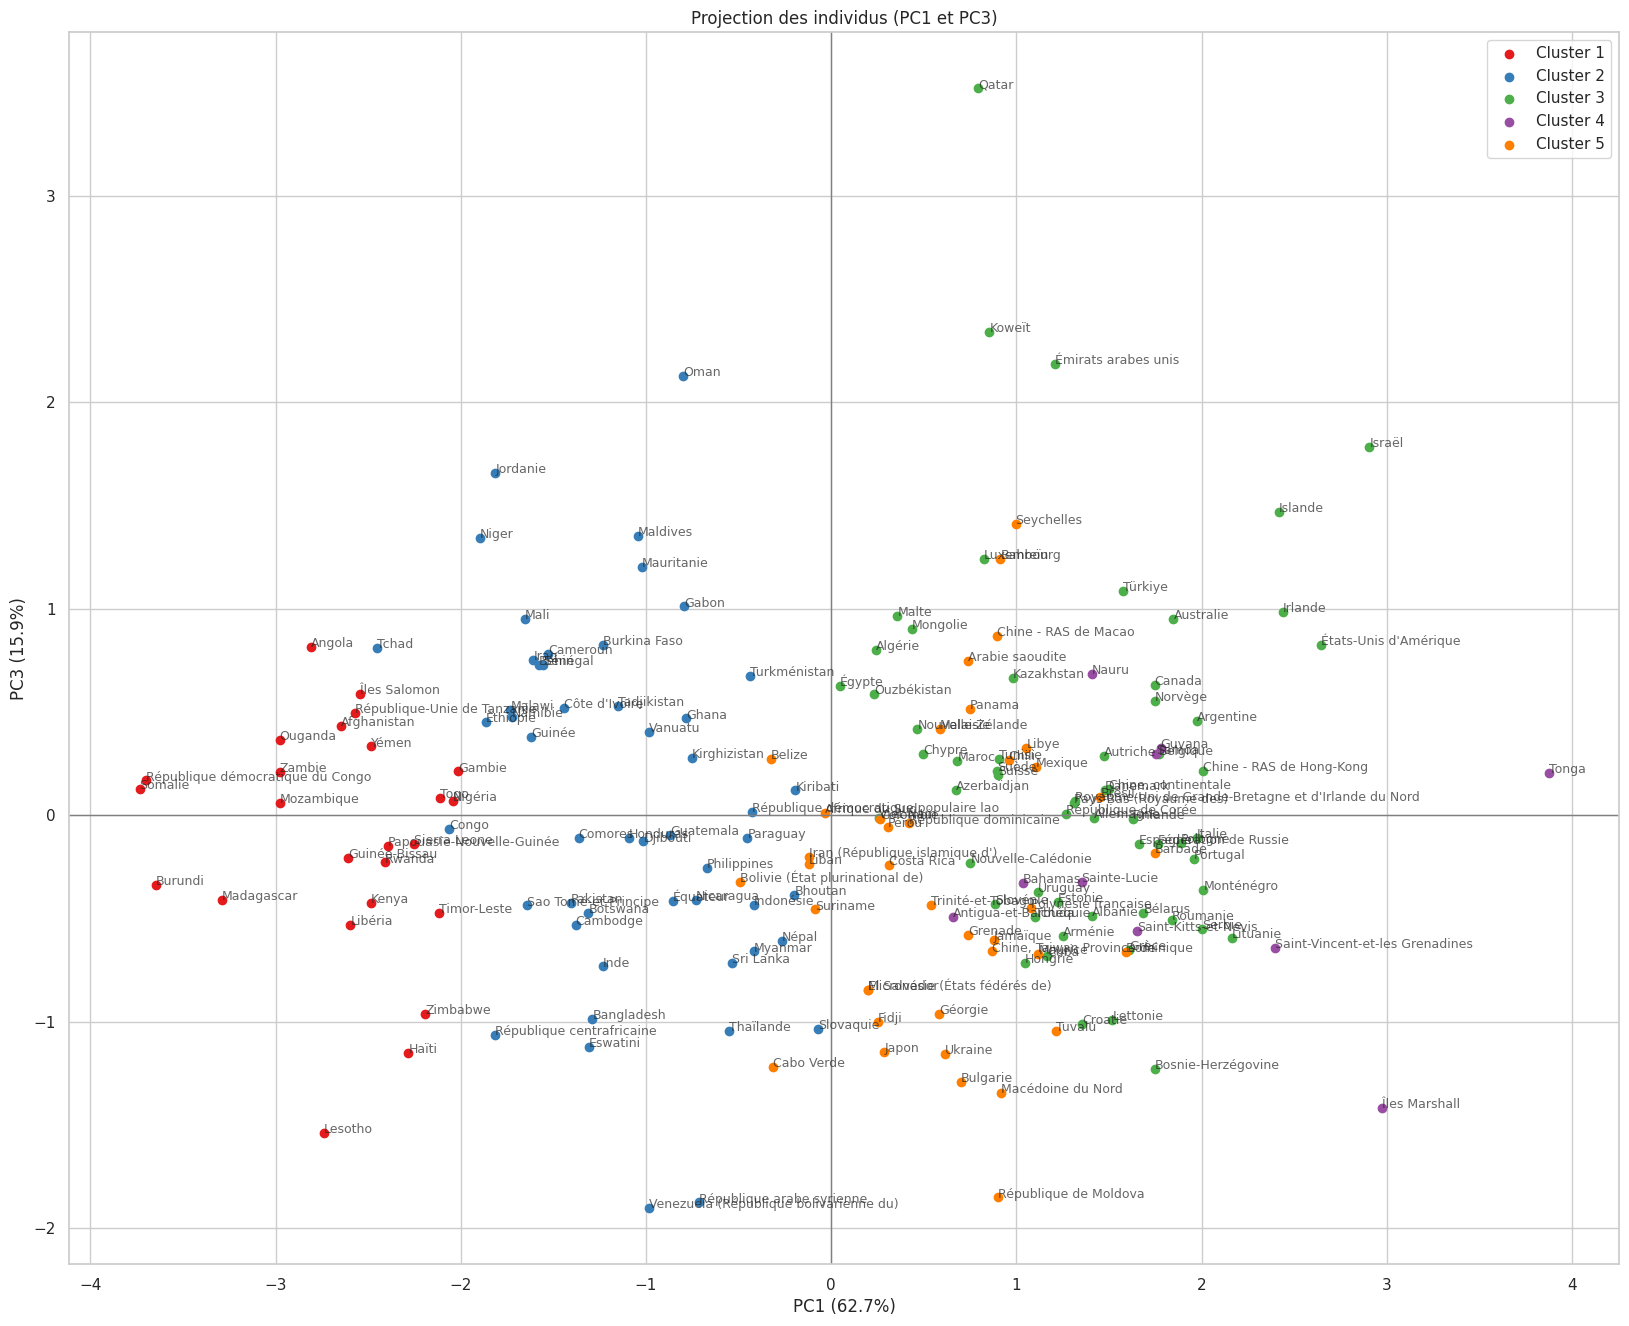

In [1049]:
x_y = 0,2
display_factorial_planes2(X_proj, x_y, pca, labels=names, figsize=(20,16), clusters=df_clustered['cluster'], palette=cluster_palette, marker="o")

Les **clusters 3 et 5** sont les plus intéressants pour une stratégie d’export de poulet basée uniquement sur l’analyse ACP:




 🟩 **Cluster 3 : Marchés matures, solvables et exigeants**

* Haute consommation de protéines et de calories.

* Forte présence du poulet → habitudes déjà ancrées.

* Faible croissance démographique → marchés stables.

* Pouvoir d’achat élevé.

    * ->  Idéal pour des produits différenciés, premium, ou des gammes à haute valeur ajoutée (produits transformés, bio, labelisés...).


🟧 **Cluster 5 : Marchés en croissance avec une bonne base nutritionnelle**

* Apports protéiques et caloriques satisfaisants.

* Consommation de poulet modérée mais significative.

* Croissance démographique positive → augmentation future de la demande.

* Pouvoir d’achat intermédiaire.

    * ->  Excellent compromis entre potentiel de volume et accessibilité.Parfait pour démarrer l'export avec une offre standardisée ou évolutive.


In [1085]:
columns_clustering = df_clustered.select_dtypes(include=[np.number]).drop(columns=['cluster'], errors='ignore').columns


nb_centroid_dims = centroids.shape[1]
columns_matched = columns_clustering[:nb_centroid_dims]


centroids_projected = pca.transform(centroids)


centroids_names = [f'Cluster {i}' for i in range(len(centroids))]


dfc1 = pd.DataFrame(centroids, columns=columns_matched, index=centroids_names)


n_components = centroids_projected.shape[1]
projected_names = [f'PC{i+1}' for i in range(n_components)]
dfc2 = pd.DataFrame(centroids_projected, columns=projected_names, index=centroids_names)


dfc3 = dfc1.merge(dfc2, left_index=True, right_index=True)


os.makedirs('Livrables', exist_ok=True)
dfc3.to_csv('Livrables/centroids.csv')


files.download('Livrables/centroids.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Kmeans

##  Ajout de critères de sélection stratégiques

In [1054]:
clusters_selection = [3, 5]


df_clustered = df_clustered.merge(poulet2[['Pays','import_ratio']], on="Pays", how="left")
df_clustered = df_clustered.merge(pib_stab[['Pays','PIB_habitant', 'stab']], on="Pays", how="left")
df_clustered = df_clustered.merge(df_pop[['Pays','pop_2021']], on="Pays", how="left")

df_selected = df_clustered[df_clustered['cluster'].isin(clusters_selection)].copy()


In [1055]:
df_selected.head(15)

Pays  poulet_g_pers_jr  \
1                    Afrique du Sud             17.85   
2                           Albanie              5.56   
3                           Algérie              2.78   
4                         Allemagne              4.92   
7                   Arabie saoudite             18.66   
8                         Argentine             21.32   
9                           Arménie              8.42   
10                        Australie             20.93   
11                         Autriche              5.26   
12                      Azerbaïdjan              6.63   
14                          Bahreïn             15.64   
16                          Barbade             21.68   
17                         Belgique              4.70   
18                           Belize             14.70   
20  Bolivie (État plurinational de)             19.04   

    proteines_total_g_pers_jr  pop_evo_ratio  kcal_total_pers_jr  cluster  \
1                       82.27      16.053147             2772.36        5   
2                      115.71      -2.124984             3330.25        3   
3                       95.33      21.292694             3499.10        3   
4                      110.54       3.511359             3620.22        3   
7                       94.22      20.006133             3250.44        5   
8                      120.06       8.582709             3345.04        3   
9                      108.88      -1.810369             3228.37        3   
10                     118.00      15.465649             3478.50        3   
11                     108.46       6.836275             3784.13        3   
12                      98.46      10.568336             3355.87        3   
14                     101.86      24.449255             3479.51        5   
16                     109.48       2.175716             3189.93        5   
17                     113.61       4.821368             3898.19        3   
18                      81.20      20.790839             2801.28        5   
20                      80.09      15.348748             2359.61        5   

    import_ratio  PIB_habitant  stab   pop_2021  
1       0.153211       13711.3 -0.75  61502.603  
2       0.623360       16126.8  0.20   2849.635  
3       0.000001       14496.9 -0.99  44761.099  
4       0.305667       62530.8  0.73  83697.083  
7       0.391351       62690.5 -0.59  31328.375  
8       0.002980       26300.3   NaN  45312.281  
9       0.721021       15921.7 -0.80   2870.349  
10      0.000204       58182.3  0.84  25956.418  
11      0.271101       62968.9  0.90   8967.057  
12      0.182713       20111.4 -0.84  10234.371  
14      0.860662       54954.7 -0.52   1501.764  
16      0.024713       15683.9  1.12    282.147  
17      0.323040       60669.2  0.66  11570.844  
18      0.001017       11677.5  0.27    395.346  
20      0.007804        9454.2 -0.28  11937.360

In [ ]:
#df_selected.columns.tolist()


## Filtrage des pays faiblement peuplés

Nous allons supprimer les Pays a moins d'un million d'habitants

In [1056]:
df_supp_pays = df_selected.copy()

In [1057]:
pays_supprimes = df_supp_pays[df_supp_pays["pop_2021"] < 1_000]["Pays"].tolist()
pays_supprimes


['Barbade',
 'Belize',
 'Cabo Verde',
 'Chine - RAS de Macao',
 'Dominique',
 'Fidji',
 'Grenade',
 'Islande',
 'Luxembourg',
 'Malte',
 'Micronésie (États fédérés de)',
 'Monténégro',
 'Nouvelle-Calédonie',
 'Polynésie française',
 'Seychelles',
 'Suriname',
 'Tuvalu']

In [1058]:
df_selected = df_supp_pays[df_supp_pays["pop_2021"] >= 1_000]


In [1059]:
pays_cibles = df_selected['Pays'].tolist()
pays_cibles

['Afrique du Sud',
 'Albanie',
 'Algérie',
 'Allemagne',
 'Arabie saoudite',
 'Argentine',
 'Arménie',
 'Australie',
 'Autriche',
 'Azerbaïdjan',
 'Bahreïn',
 'Belgique',
 'Bolivie (État plurinational de)',
 'Bosnie-Herzégovine',
 'Brésil',
 'Bulgarie',
 'Bélarus',
 'Canada',
 'Chili',
 'Chine - RAS de Hong-Kong',
 'Chine, Taiwan Province de',
 'Chine, continentale',
 'Chypre',
 'Colombie',
 'Costa Rica',
 'Croatie',
 'Cuba',
 'Danemark',
 'El Salvador',
 'Espagne',
 'Estonie',
 'Finlande',
 'Fédération de Russie',
 'Grèce',
 'Géorgie',
 'Hongrie',
 "Iran (République islamique d')",
 'Irlande',
 'Israël',
 'Italie',
 'Jamaïque',
 'Japon',
 'Kazakhstan',
 'Koweït',
 'Lettonie',
 'Liban',
 'Libye',
 'Lituanie',
 'Macédoine du Nord',
 'Malaisie',
 'Maroc',
 'Maurice',
 'Mexique',
 'Mongolie',
 'Norvège',
 'Nouvelle-Zélande',
 'Ouzbékistan',
 'Panama',
 'Pays-Bas (Royaume des)',
 'Pologne',
 'Portugal',
 'Pérou',
 'Qatar',
 'Roumanie',
 "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord"

In [1060]:
df_selected.columns.tolist()

['Pays',
 'poulet_g_pers_jr',
 'proteines_total_g_pers_jr',
 'pop_evo_ratio',
 'kcal_total_pers_jr',
 'cluster',
 'import_ratio',
 'PIB_habitant',
 'stab',
 'pop_2021']

In [1061]:

df_kmeans = df_selected[['Pays', 'PIB_habitant', 'stab', 'import_ratio', 'pop_2021']].copy()


In [1062]:

df_kmeans_clean = df_kmeans.dropna().copy()


In [1063]:
df_kmeans_clean.head()

Pays  PIB_habitant  stab  import_ratio   pop_2021
1   Afrique du Sud       13711.3 -0.75      0.153211  61502.603
2          Albanie       16126.8  0.20      0.623360   2849.635
3          Algérie       14496.9 -0.99      0.000001  44761.099
4        Allemagne       62530.8  0.73      0.305667  83697.083
7  Arabie saoudite       62690.5 -0.59      0.391351  31328.375

## Standardisation des variables

In [1064]:
features = ['PIB_habitant', 'stab', 'import_ratio', 'pop_2021']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans_clean[features])


## Methode du coude pour le choix du nombre de cluster

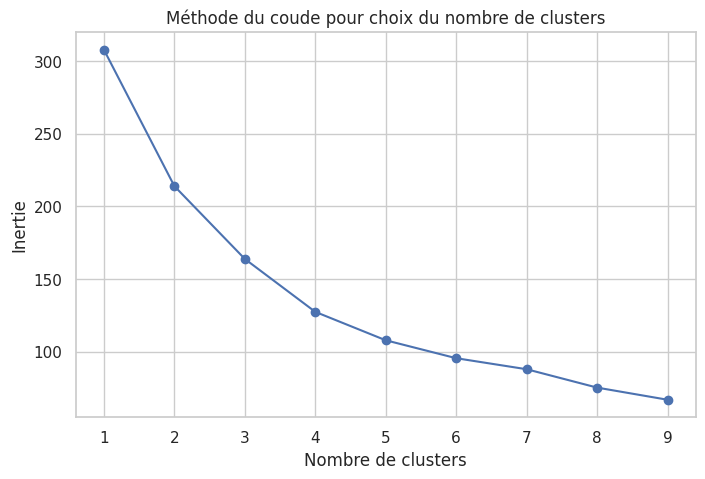

In [1065]:

inertias = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour choix du nombre de clusters')
plt.grid(True)
plt.show()


Le coude se trouve a 4 clusters

In [1070]:

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df_kmeans_clean['cluster_kmeans'] = kmeans.fit_predict(X_scaled)
df_kmeans_cluster = df_kmeans_clean.copy()


In [1071]:
df_kmeans_cluster.head()

Pays  PIB_habitant  stab  import_ratio   pop_2021  \
1   Afrique du Sud       13711.3 -0.75      0.153211  61502.603   
2          Albanie       16126.8  0.20      0.623360   2849.635   
3          Algérie       14496.9 -0.99      0.000001  44761.099   
4        Allemagne       62530.8  0.73      0.305667  83697.083   
7  Arabie saoudite       62690.5 -0.59      0.391351  31328.375   

   cluster_kmeans  
1               1  
2               2  
3               1  
4               3  
7               3

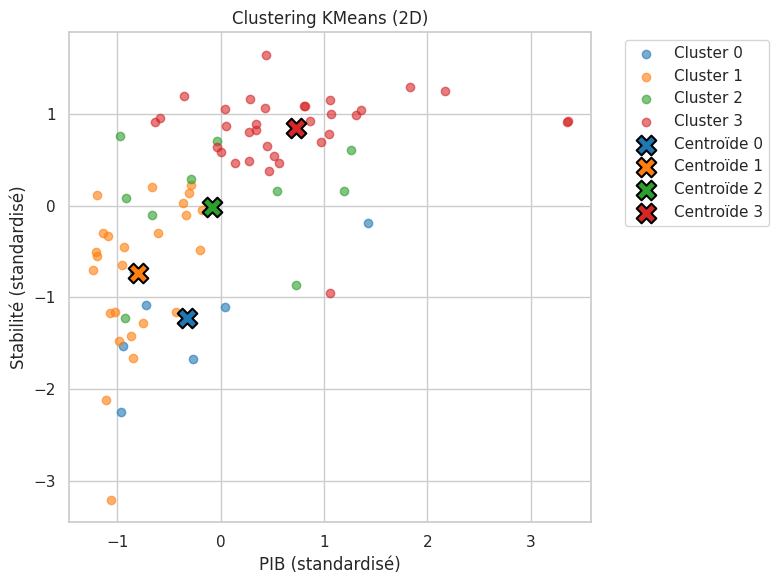

In [1074]:
colors = plt.cm.tab10.colors

plt.figure(figsize=(8, 6))


for cluster in range(k):
    cluster_data = X_scaled[df_kmeans_cluster['cluster_kmeans'] == cluster]
    plt.scatter(
        cluster_data[:, 0],
        cluster_data[:, 1],
        label=f'Cluster {cluster}',
        color=colors[cluster],
        alpha=0.6
    )


centroids = kmeans.cluster_centers_
for cluster in range(k):
    plt.scatter(
        centroids[cluster, 0],
        centroids[cluster, 1],
        c=[colors[cluster]],
        marker='X',
        s=200,
        edgecolors='black',
        linewidths=1.5,
        label=f'Centroïde {cluster}'
    )

plt.xlabel('PIB (standardisé)')
plt.ylabel('Stabilité (standardisé)')
plt.title('Clustering KMeans (2D)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

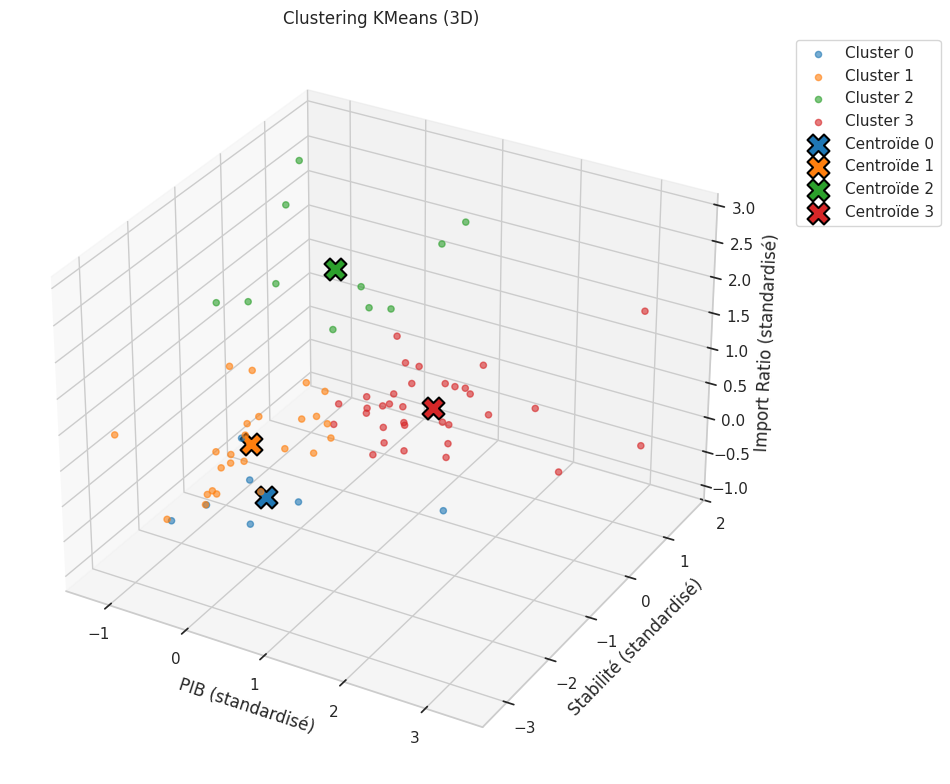

In [1076]:
from mpl_toolkits.mplot3d import Axes3D
colors = plt.cm.tab10.colors

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


for cluster in range(k):
    cluster_data = X_scaled[df_kmeans_cluster['cluster_kmeans'] == cluster]
    ax.scatter(
        cluster_data[:, 0],
        cluster_data[:, 1],
        cluster_data[:, 2],
        label=f'Cluster {cluster}',
        color=colors[cluster],
        alpha=0.6
    )


for cluster in range(k):
    ax.scatter(
        centroids[cluster, 0],
        centroids[cluster, 1],
        centroids[cluster, 2],
        c=[colors[cluster]],
        marker='X',
        s=250,
        edgecolors='black',
        linewidths=1.5,
        label=f'Centroïde {cluster}'
    )


ax.set_xlabel('PIB (standardisé)')
ax.set_ylabel('Stabilité (standardisé)')
ax.set_zlabel('Import Ratio (standardisé)')
ax.set_title('Clustering KMeans (3D)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Visualisons la composition de nos clusters

In [1077]:

df_kmeans_cluster['cluster_kmeans'] = kmeans.predict(X_scaled)

for i in range(k):
    print(f"\nCluster {i} :")
    display(df_kmeans_cluster[df_kmeans_cluster['cluster_kmeans'] == i][['Pays']])



Cluster 0 :


Pays
23                           Brésil
55             Fédération de Russie
71   Iran (République islamique d')
102                         Mexique
169                         Türkiye
178                          Égypte
181           États-Unis d'Amérique


Cluster 1 :


Pays
1                     Afrique du Sud
3                            Algérie
12                       Azerbaïdjan
20   Bolivie (État plurinational de)
21                Bosnie-Herzégovine
27                           Bélarus
33                             Chili
39                          Colombie
49                       El Salvador
60                             Grèce
77                          Jamaïque
80                        Kazakhstan
87                             Liban
88                             Libye
94                          Malaisie
99                             Maroc
119                      Ouzbékistan
121                           Panama
129                            Pérou
137            République de Moldova
138           République dominicaine
147                           Serbie
165                Trinité-et-Tobago
166                          Tunisie
170                          Ukraine
174                         Viet Nam


Cluster 2 :


Pays
2                     Albanie
9                     Arménie
14                    Bahreïn
24                   Bulgarie
34   Chine - RAS de Hong-Kong
65                    Géorgie
84                     Koweït
86                   Lettonie
92          Macédoine du Nord
104                  Mongolie
179       Émirats arabes unis


Cluster 3 :


Pays
4                                            Allemagne
7                                      Arabie saoudite
10                                           Australie
11                                            Autriche
17                                            Belgique
32                                              Canada
38                                              Chypre
42                                          Costa Rica
43                                             Croatie
46                                            Danemark
50                                             Espagne
51                                             Estonie
54                                            Finlande
68                                             Hongrie
73                                             Irlande
76                                              Italie
78                                               Japon
90                                            Lituanie
100                                            Maurice
113                                            Norvège
115                                   Nouvelle-Zélande
124                             Pays-Bas (Royaume des)
126                                            Pologne
128                                           Portugal
130                                              Qatar
131                                           Roumanie
132  Royaume-Uni de Grande-Bretagne et d'Irlande du...
136                                République de Corée
151                                           Slovénie
154                                             Suisse
156                                              Suède
160                                           Tchéquie
171                                            Uruguay

In [1078]:

centroides = df_kmeans_cluster.groupby('cluster_kmeans').mean(numeric_only=True)
display(centroides)

PIB_habitant      stab  import_ratio       pop_2021
cluster_kmeans                                                     
0               30096.185714 -0.797143      0.050286  158470.686714
1               18810.038462 -0.424231      0.139712   22483.873923
2               35879.645455  0.124545      0.756234    4236.198545
3               54949.318182  0.776364      0.191106   22072.183273

In [1079]:

columns = ['PIB_habitant', 'stab', 'pop_2021', 'import_ratio',]
pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=columns)



PIB_habitant      stab  pop_2021   import_ratio
0  30096.185714 -0.797143  0.050286  158470.686714
1  18810.038462 -0.424231  0.139712   22483.873923
2  35879.645455  0.124545  0.756234    4236.198545
3  54949.318182  0.776364  0.191106   22072.183273

Cluster 0 : Pays pauvres et instables, très dépendants des importations

Cluster 1 : Revenu modéré, très stables, forte population, très faible importation


Cluster 2: Pays moyennement développés, stabilité incertaine, import modéré

Cluster 3 : Pays riches, stables, forte population, importation faible.


Nous allons donc séléctionner le Cluster 3

In [1080]:

cluster_final = df_kmeans_clean[df_kmeans_clean['cluster_kmeans'] == 3]

cluster_final_sorted = cluster_final.sort_values(by='PIB_habitant', ascending=False)

display(cluster_final_sorted[['Pays', 'PIB_habitant', 'stab']])


Pays  PIB_habitant  stab
73                                             Irlande      116904.0  0.84
130                                              Qatar      116833.0  0.83
113                                            Norvège       88984.1  1.09
154                                             Suisse       81001.4  1.12
46                                            Danemark       69715.2  0.93
124                             Pays-Bas (Royaume des)       68573.6  0.89
11                                            Autriche       62968.9  0.90
156                                              Suède       62731.7  1.01
7                                      Arabie saoudite       62690.5 -0.59
4                                            Allemagne       62530.8  0.73
17                                            Belgique       60669.2  0.66
10                                           Australie       58182.3  0.84
32                                              Canada       56995.1  0.96
54                                            Finlande       56790.4  0.96
132  Royaume-Uni de Grande-Bretagne et d'Irlande du...       51004.4  0.49
76                                              Italie       49825.4  0.55
38                                              Chypre       48781.3  0.42
136                                République de Corée       48419.6  0.63
115                                   Nouvelle-Zélande       47996.7  1.39
160                                           Tchéquie       47796.0  0.95
151                                           Slovénie       45914.1  0.76
90                                            Lituanie       45873.5  0.81
78                                               Japon       44355.3  1.02
50                                             Espagne       44251.7  0.51
51                                             Estonie       44251.5  0.75
126                                            Pologne       41059.6  0.49
68                                             Hongrie       38887.2  0.80
128                                           Portugal       38657.7  0.94
131                                           Roumanie       37730.4  0.58
43                                             Croatie       36930.5  0.62
171                                            Uruguay       29431.9  1.05
42                                          Costa Rica       23852.9  0.86
100                                            Maurice       22737.6  0.83

#  Sélection des pays à cibler

#  Analyse pondérée

Si Nous nous limitions a une analyse sur les scores, voici la liste des pays dans l'ordre de séléctions selon notre pondération

In [1083]:

from sklearn.preprocessing import MinMaxScaler


df_final =cluster_final_sorted.copy()

pays_schengen = [
   'Allemagne' ,'Autriche' , 'Belgique' , 'Croatie' ,'Danemark' , 'Espagne' , 'Estonie' , 'Finlande' , 'Grèce' , 'Hongrie' , 'Islande (voir section suivante, non-UE)' , 'Italie' , 'Lettonie' , 'Liechtenstein' , 'Lituanie' , 'Luxembourg' , 'Malte' ,'Pays-Bas' , 'Pologne' , 'Portugal' , 'Slovénie' , 'Slovaquie' , 'Tchéquie' ,'Suède'
]

#df_final["schengen"] = df_final["Pays"].apply(lambda x: 1 if x in pays_schengen else 0)
  # df_final["schengen"] * 4  +

scaler = MinMaxScaler()
df_final[[ "pib_norm"]] = scaler.fit_transform(df_final[[ "PIB_habitant"]])
df_final[[ "stab_norm"]] = scaler.fit_transform(df_final[[ "stab"]])

df_final["score"] = (
    df_final["pib_norm"] * 2 +
    df_final["stab"] * 1
)


df_top10 = df_final.sort_values(by="score", ascending=False).head(10)
display(df_top10[["Pays", "PIB_habitant", "stab", "score"]])


Pays  PIB_habitant  stab     score
73                  Irlande      116904.0  0.84  2.840000
130                   Qatar      116833.0  0.83  2.828492
113                 Norvège       88984.1  1.09  2.497009
154                  Suisse       81001.4  1.12  2.357465
46                 Danemark       69715.2  0.93  1.927757
115        Nouvelle-Zélande       47996.7  1.39  1.926478
124  Pays-Bas (Royaume des)       68573.6  0.89  1.863511
156                   Suède       62731.7  1.01  1.859435
11                 Autriche       62968.9  0.90  1.754473
32                   Canada       56995.1  0.96  1.687595

In [1082]:
pays_selectionné= df_top10['Pays'].tolist()
pays_selectionné

['Irlande',
 'Qatar',
 'Norvège',
 'Suisse',
 'Danemark',
 'Pays-Bas (Royaume des)',
 'Suède',
 'Nouvelle-Zélande',
 'Autriche',
 'Canada']

Si Nous nous limitions aux analyses mathématiques, les pays séléctionnés seraient:

'Danemark',
 'Suède',
 'Autriche',
 'Finlande',
 'Tchéquie',
 'Allemagne',
 'Belgique',
 'Portugal',
 'Lituanie',
 'Slovénie']

Cependant nous allons faire une analyse métier pour notre choix définitif

#  Analyse métier

nous allons répartir les groupe en Zone géographique:

In [1089]:
pays_en_fr_to_en = {
   "Irlande": "Ireland",
"Norvège": "Norway",
"Suisse": "Switzerland",
"Danemark": "Denmark",
"Pays-Bas (Royaume des)": "Netherlands",
"Autriche": "Austria",
"Suède": "Sweden",
"Allemagne": "Germany",
"Islande": "Iceland",
"Belgique": "Belgium",
"Australie": "Australia",
"Canada": "Canada",
"Finlande": "Finland",
"Royaume-Uni de Grande-Bretagne et d'Irlande du Nord": "United Kingdom",
"Italie": "Italy",
"Chypre": "Cyprus",
"République de Corée": "South Korea",
"Nouvelle-Zélande": "New Zealand",
"Tchéquie": "Czechia",
"Slovénie": "Slovenia",
"Lituanie": "Lithuania",
"Japon": "Japan",
"Espagne": "Spain",
"Estonie": "Estonia",
"Pologne": "Poland",
"Hongrie": "Hungary",
"Portugal": "Portugal",
"Roumanie": "Romania",
"Croatie": "Croatia",
"Panama": "Panama",
"Uruguay": "Uruguay",
"Costa Rica": "Costa Rica",
"Maurice": "Mauritius",
"Barbade": "Barbados",
"Fidji": "Fiji"

}
df_kmeans_cluster['country'] = df_kmeans_cluster['Pays'].replace(pays_en_fr_to_en)

In [1090]:

fig = px.choropleth(df_kmeans_cluster[df_kmeans_cluster['cluster_kmeans'] == 3],
                    locations='country',
                    locationmode='country names',
                    color='cluster_kmeans',
                    title="Répartition géographique des clusters",
                    color_continuous_scale='Viridis')
fig.show()

In [1091]:
pays_final= df_final['Pays'].tolist()
pays_final

['Irlande',
 'Qatar',
 'Norvège',
 'Suisse',
 'Danemark',
 'Pays-Bas (Royaume des)',
 'Autriche',
 'Suède',
 'Arabie saoudite',
 'Allemagne',
 'Belgique',
 'Australie',
 'Canada',
 'Finlande',
 "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord",
 'Italie',
 'Chypre',
 'République de Corée',
 'Nouvelle-Zélande',
 'Tchéquie',
 'Slovénie',
 'Lituanie',
 'Japon',
 'Espagne',
 'Estonie',
 'Pologne',
 'Hongrie',
 'Portugal',
 'Roumanie',
 'Croatie',
 'Uruguay',
 'Costa Rica',
 'Maurice']

##  Synthèse des pays retenus

🟡 Zone 1 — Europe du Nord & Scandinavie

Norvège

Suède

Finlande

Danemark

Estonie

Lituanie

🟤 Îles Britanniques
& Atlantique Nord

Irlande

Royaume-Uni

Islande

🟣  DACH / Benelux

Allemagne

Autriche

Suisse

Pays-Bas

Belgique

🔵  Europe Centrale

Tchéquie

Slovénie

Pologne

Hongrie

Roumanie

Croatie

Chypre

🔴 Europe du Sud

Espagne

Italie

Portugal



🌍 Reste du monde


Australie

Nouvelle-Zélande

Canada

Japon

République de Corée

Panama

Uruguay

Costa Rica

Maurice

Barbade

Fidji

##  Stratégie métier

Notre recommandation de ciblage repose sur une logique progressive, combinant facilité d’accès au marché, logistique optimisée et homogénéité réglementaire.

1. **Priorité à l’espace Schengen**

Nous avons choisi de concentrer l’analyse sur les pays membres de l’espace Schengen, pour plusieurs raisons stratégiques :

Liberté de circulation des marchandises

Absence de contrôle douanier aux frontières intérieures

Harmonisation des règles sanitaires et vétérinaires

-> Cela permet de simplifier les démarches administratives et de réduire les coûts d'entrée sur le marché.

    

2. **Ciblage des pays de la zone Euro**

Nous privilégions ensuite les pays de la zone Euro, afin de :

Éviter les risques de change

Simplifier la facturation et les opérations financières

Accroître la stabilité des transactions



3. **Démarrage par les pays frontaliers**

Pour une première phase d’expansion, il est recommandé de cibler en priorité les pays frontaliers :

Moins de risques logistiques

Meilleure maîtrise de la chaîne du froid

Accès plus rapide aux clients finaux

 Objectif : valider le modèle d’export sur des marchés proches, à moindre coût.



4. **Expansion par zones géographiques homogènes**

Enfin, une stratégie d’expansion progressive par grandes régions est proposée :

Basée sur la proximité culturelle, les habitudes alimentaires et les infrastructures

Appuyée par notre segmentation statistique (clustering et ACP)

### 1) Priorité à l’espace Schengen

Nous avons choisi de concentrer l’analyse sur les pays membres de l’espace Schengen, pour plusieurs raisons stratégiques :

Liberté de circulation des marchandises

Absence de contrôle douanier aux frontières intérieures

Harmonisation des règles sanitaires et vétérinaires

-> Cela permet de simplifier les démarches administratives et de réduire les coûts d'entrée sur le marché.

### 2) Ciblage des pays de la zone Euro

Nous privilégions ensuite les pays de la zone Euro, afin de :

Éviter les risques de change

Simplifier la facturation et les opérations financières

Accroître la stabilité des transactions

### 3) Démarrage par les pays frontaliers

Pour une première phase d’expansion, il est recommandé de cibler en priorité les pays frontaliers :

Moins de risques logistiques

Meilleure maîtrise de la chaîne du froid

Accès plus rapide aux clients finaux

 Objectif : valider le modèle d’export sur des marchés proches, à moindre coût.

### 4) Expansion par zones géographiques homogènes

Enfin, une stratégie d’expansion progressive par grandes régions est proposée :

Basée sur la proximité culturelle, les habitudes alimentaires et les infrastructures

Appuyée par notre segmentation statistique (clustering et ACP)

## Feuille de route du projet d'exportation

Nous allons donc faire une expention par étape:

1)  DACH / Benelux

Allemagne

Autriche

Suisse

Pays-Bas

Belgique

2) Europe du Sud / Méditerranée

Espagne

Italie

Portugal

3)Îles Britanniques & Atlantique Nord

Irlande

Royaume-Uni de Grande-Bretagne et d'Irlande du Nord

Islande

###1)  DACH / Benelux

Allemagne

Autriche

Suisse

Pays-Bas

Belgique

### 2) Europe du Sud "Méditerranée"

Espagne

Italie

Portugal

### 3) Îles Britanniques & Atlantique Nord

Irlande

Royaume-Uni de Grande-Bretagne et d'Irlande du Nord

Islande

# Limites méthodologiques ou de données

## Qualité des données FAO

Les données alimentaires utilisées (disponibilité en protéines, calories, etc.) proviennent de la FAO, qui compile des moyennes nationales.

 Ces données peuvent parfois masquer des disparités régionales importantes au sein d’un même pays comme le Canada, les USA ou la chine par exemple.

* Limite : Moyennes nationales ≠ réalités locales
* Conséquence : Risque de surestimer ou sous-estimer le potentiel réel d’un marché

## Année des données / obsolescence



Certaines données datent de quelques années. Les comportements alimentaires ou les volumes d'import/export ont pu évoluer depuis.

* Limite : Décalage temporel
* Conséquence : Moins bonne précision dans un contexte post-COVID ou inflationniste

## Clustering = simplification




"Le clustering K-Means ou CAH repose sur une réduction multidimensionnelle. Il simplifie des dynamiques complexes à quelques groupes seulement."

* Limite : Simplification excessive
* Conséquence : Perte de nuances culturelles, économiques, logistiques

## Choix des variables

Le choix des variables alimentaires (protéines, calories, part animale) ne couvre pas tous les facteurs importants : pouvoir d'achat, habitudes religieuses, réglementation d’importation…

* Limite : Variables partiellement représentatives du marché réel
* Conséquence : Ciblage partiel ou biaisé si non complété

## Frontières linguistiques, culturelles, ou réglementaires non intégrées

La segmentation ne prend pas encore en compte les barrières culturelles ou linguistiques qui pourraient freiner l’entrée sur un marché.


# Analyse statistique comparative

## Test de normalité (Shapiro / D’Agostino)

Pour procéder a nos analyses statistiques, nous allons utiliser notre datafram df_dendo qui regroupe nos variables actives

In [1092]:
df_dendo.columns

Index(['poulet_g_pers_jr', 'proteines_total_g_pers_jr', 'pop_evo_ratio',
       'kcal_total_pers_jr'],
      dtype='object')

In [1093]:
df_dendo

poulet_g_pers_jr  proteines_total_g_pers_jr  \
Pays                                                                 
Afghanistan                        0.68                      61.16   
Afrique du Sud                    17.85                      82.27   
Albanie                            5.56                     115.71   
Algérie                            2.78                      95.33   
Allemagne                          4.92                     110.54   
...                                 ...                        ...   
Équateur                          12.41                      69.00   
États-Unis d'Amérique             20.66                     122.10   
Éthiopie                           0.18                      76.83   
Îles Marshall                     29.38                     114.74   
Îles Salomon                       3.21                      58.96   

                       pop_evo_ratio  kcal_total_pers_jr  
Pays                                                      
Afghanistan                36.298249             2239.62  
Afrique du Sud             16.053147             2772.36  
Albanie                    -2.124984             3330.25  
Algérie                    21.292694             3499.10  
Allemagne                   3.511359             3620.22  
...                              ...                 ...  
Équateur                   15.373823             2561.75  
États-Unis d'Amérique       8.295429             3892.91  
Éthiopie                   31.120373             2463.44  
Îles Marshall             -20.305546             3208.40  
Îles Salomon               37.914440             2311.29  

[185 rows x 4 columns]

In [1095]:


alpha = 0.01
test_df = df_dendo

for var in test_df.columns:
    k2, p = st.normaltest(test_df[var])

    if p > alpha:
        print(f"{var} : Hypothèse nulle non rejetée. (p-value = {p:.4f})")
    else:
        print(f"{var} : Hypothèse nulle rejetée. (p-value = {p:.4f})")


poulet_g_pers_jr : Hypothèse nulle rejetée. (p-value = 0.0000)
proteines_total_g_pers_jr : Hypothèse nulle non rejetée. (p-value = 0.0676)
pop_evo_ratio : Hypothèse nulle non rejetée. (p-value = 0.0884)
kcal_total_pers_jr : Hypothèse nulle non rejetée. (p-value = 0.1232)






Un test de normalité de D’Agostino–Pearson test a été appliqué à l’ensemble des variables.
La variable proteines_total_g_pers_jr présente une p-value de 0,0676, supérieure au seuil α = 0,01, ce qui signifie que nous ne rejetons pas l’hypothèse de normalité.
Cette variable a donc été retenue pour le test comparatif.

Nous choisissons la variables "proteines_total_g_pers_jr" qui suit la loi normale.

## Test de Levene et T test

**Le test t** est une procédure de test statistique qui permet de vérifier s'il existe une différence significative entre les moyennes de deux groupes.

**Le test de Levene**
consiste à effectuer une analyse de variance en prenant les valeurs absolues des écarts à la moyenne comme variable dépendante. Pour cette raison, les échantillons doivent être issus de populations dont la distribution suit une loi normale.

Afin de vérifier que les groupes obtenus par le clustering diffèrent réellement sur certaines dimensions, nous avons sélectionné une variable gaussienne et effectué un test de comparaison de moyennes sur deux clusters représentatifs.

In [1097]:

cluster1 = df_clustered.loc[df_clustered['cluster'] == 1, 'proteines_total_g_pers_jr']
cluster5 = df_clustered.loc[df_clustered['cluster'] == 5, 'proteines_total_g_pers_jr']

 F, p_anova = st.f_oneway(cluster1,cluster5)
    print(f"{var} — ANOVA p={p_anova:.4g}")

    if p_anova < 0.05:
        print(f"{var} : Hypothèse nulle non rejetée. (p-value = {p_anova:.4f})")
# Test de Levene (homogénéité des variances)
W, p_levene = st.levene(cluster1, cluster5)
print(f"Levene p-value = {p_levene:.4f}")

# Test de Student
equal_var = p_levene > 0.05
t_stat, p_ttest = st.ttest_ind(cluster1, cluster5, equal_var=equal_var)
print(f"T-test p-value = {p_ttest:.4e}")

if p_ttest < 0.05:
    print(" Différence significative entre les deux clusters.")
else:
    print(" Pas de différence significative entre les deux clusters.")


IndentationError: unexpected indent (ipython-input-1532362463.py, line 4)

In [1101]:
var = 'proteines_total_g_pers_jr'

# Extraction des valeurs pour les deux clusters choisis
cluster1 = df_clustered.loc[df_clustered['cluster'] == 1, var]
cluster5 = df_clustered.loc[df_clustered['cluster'] == 5, var]

# Facultatif : ANOVA (utile si plus de deux groupes)
F, p_anova = st.f_oneway(cluster1, cluster5)
print(f"ANOVA sur {var} — p-value = {p_anova:.4g}")
if p_anova < 0.05:
    print(" → Différence significative entre les groupes (ANOVA)")
else:
    print(" → Pas de différence significative (ANOVA)")

# Test de Levene (homogénéité des variances)
W, p_levene = st.levene(cluster1, cluster5)
print(f"Test de Levene — p-value = {p_levene:.4g}")

# Choix du t-test selon Levene
equal_var = p_levene > 0.05  # True si variances homogènes
t_stat, p_ttest = st.ttest_ind(cluster1, cluster5, equal_var=equal_var)

print(f"Test de Student sur {var} — p-value = {p_ttest:.4e}")
if p_ttest < 0.05:
    print(" → Différence significative entre les deux clusters.")
else:
    print(" → Pas de différence significative entre les deux clusters.")

ANOVA sur proteines_total_g_pers_jr — p-value = 2.281e-23
 → Différence significative entre les groupes (ANOVA)
Test de Levene — p-value = 0.3306
Test de Student sur proteines_total_g_pers_jr — p-value = 2.2811e-23
 → Différence significative entre les deux clusters.


In [1103]:


var = 'proteines_total_g_pers_jr'

# Extraction des valeurs pour les deux clusters choisis
cluster1 = df_clustered.loc[df_clustered['cluster'] == 1, var]
cluster5 = df_clustered.loc[df_clustered['cluster'] == 5, var]

# Statistiques descriptives
mean1, std1 = cluster1.mean(), cluster1.std()
mean5, std5 = cluster5.mean(), cluster5.std()
print(f"Moyenne Cluster 1 : {mean1:.2f} ± {std1:.2f}")
print(f"Moyenne Cluster 5 : {mean5:.2f} ± {std5:.2f}")

# ANOVA (facultatif si seulement deux groupes)
F, p_anova = st.f_oneway(cluster1, cluster5)
print(f"\nANOVA sur {var} — p-value = {p_anova:.4g}")
if p_anova < 0.05:
    print(" → Différence significative entre les groupes (ANOVA)")
else:
    print(" → Pas de différence significative (ANOVA)")

# Test de Levene
W, p_levene = st.levene(cluster1, cluster5)
print(f"\nTest de Levene — p-value = {p_levene:.4g}")

# Test t adapté
equal_var = p_levene > 0.05
t_stat, p_ttest = st.ttest_ind(cluster1, cluster5, equal_var=equal_var)
test_type = "Student (variances égales)" if equal_var else "Welch (variances inégales)"
print(f"\n{test_type} sur {var} — p-value = {p_ttest:.4e}")

if p_ttest < 0.05:
    print("→ Différence significative entre les deux clusters.")
else:
    print("→ Pas de différence significative entre les deux clusters.")


Moyenne Cluster 1 : 52.06 ± 8.50
Moyenne Cluster 5 : 91.84 ± 10.61

ANOVA sur proteines_total_g_pers_jr — p-value = 2.281e-23
 → Différence significative entre les groupes (ANOVA)

Test de Levene — p-value = 0.3306

Student (variances égales) sur proteines_total_g_pers_jr — p-value = 2.2811e-23
→ Différence significative entre les deux clusters.


1. **Sélection des clusters**

Nous avons choisi de comparer :

Cluster 1 : pays à faibles ressources nutritionnelles, caractérisés par un apport protéique moyen de 52,06 g/pers/jr (± 8,50).

Cluster 5 : pays riches, avec un apport protéique élevé de 91,84 g/pers/jr (± 10,61).

Ces deux groupes représentent des profils nutritionnels très contrastés. Cette opposition permet de tester efficacement si la variable proteines_total_g_pers_jr différencie réellement les clusters obtenus par le modèle de segmentation.

2. **Test global — ANOVA à un facteur**

Une ANOVA à un facteur a été réalisée pour vérifier si les moyennes des deux clusters diffèrent significativement sur la variable proteines_total_g_pers_jr.

Le test donne une p-value = 2,281 × 10⁻²³, soit une valeur très inférieure au seuil de significativité (α = 0,05).

 -> L’hypothèse nulle d’égalité des moyennes est donc rejetée : les moyennes des deux groupes diffèrent de manière hautement significative.

Cette première étape confirme qu’il existe une différence réelle entre les clusters en termes d’apport protéique.

3. **Test d’égalité des variances — Test de Levene**

Avant d’affiner la comparaison, un test de Levene a été effectué afin de vérifier l’hypothèse d’homogénéité des variances entre les deux clusters.

La p-value obtenue (0,3306) est supérieure au seuil de 0,05, ce qui signifie qu’il n’y a pas de différence significative de variances entre les deux groupes.

-> L’hypothèse d’homogénéité est donc respectée.
Le test de Student (variances égales) peut être utilisé en toute légitimité.

4. **Test de comparaison de moyennes — Test de Student**

Le test de Student (à variances égales) appliqué à la variable proteines_total_g_pers_jr aboutit à une p-value = 2,281 × 10⁻²³, extrêmement inférieure au seuil de 0,05.

-> L’hypothèse nulle d’égalité des moyennes est formellement rejetée.
Cela indique que les apports protéiques moyens diffèrent très significativement entre les pays des clusters 1 et 5.

Cette différence est non seulement statistiquement significative, mais aussi substantielle sur le plan pratique : près de 40 g de protéines par jour d’écart, soit un écart de plus de 70 % entre les deux groupes.

**Conclusion**

Les tests successifs (ANOVA, Levene et Student) convergent vers le même résultat :
les clusters 1 et 5 présentent une différence hautement significative sur la variable proteines_total_g_pers_jr.

Ces résultats confirment que la partition issue du clustering n’est pas arbitraire : elle repose bien sur des distinctions réelles et statistiquement validées entre groupes de pays, consolidant ainsi la robustesse et la pertinence du modèle de segmentation.

**liens interessants:**

https://colab.research.google.com/github/OpenClassrooms-Student-Center/4525281-realisez-une-analyse-exploratoire-de-donnees/blob/main/notebooks/P3C2_iris_k_means.ipynb#scrollTo=J_bjrmskcl0L

https://colab.research.google.com/github/OpenClassrooms-Student-Center/4525281-realisez-une-analyse-exploratoire-de-donnees/blob/main/notebooks/P3C3_iris_cah.ipynb#scrollTo=AxVElfBaMRXV

https://colab.research.google.com/github/OpenClassrooms-Student-Center/4525281-realisez-une-analyse-exploratoire-de-donnees/blob/main/notebooks/P2C6_TP_cours_effectuees.ipynb#scrollTo=7tFT1tvS8jVF